# Text Sentiment Analysis of Climate Change Tweets

In [1]:
# importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

import reverse_geocoder as rg
import pycountry

import collections
from textblob import TextBlob

from tqdm import tqdm 

## 1. Data Cleaning

In [2]:
# loading dataset into DataFrame
df = pd.read_csv('climate_change-tweets.csv')

#### a) Inspecting data

In [3]:
df.head()

date                   id  \
0  2023-03-24 18:31:03+00:00  1639334024429846533   
1  2023-03-24 15:00:43+00:00  1639281090798972930   
2  2023-03-24 14:24:07+00:00  1639271883924291584   
3  2023-03-24 13:58:58+00:00  1639265552966250496   
4  2023-03-24 12:36:59+00:00  1639244922325991426   

                                             content        username  \
0  @kajunjon I’m waiting for some “climate expert...      droachnola   
1  @andrewlukenbach It's not global warming anymo...  hammtweezy2192   
2  Watching their cherished wilderness succumb to...  sashadigiulian   
3  And maybe a couple brownies. \nThe #Obamacare ...  MandyintheWest   
4  Look up the facts- If the government supports ...        lipmannj   

                                         coordinates like_count  \
0  Coordinates(longitude=-109.050173, latitude=31...          0   
1  Coordinates(longitude=-106.7916912, latitude=3...          1   
2  Coordinates(longitude=-109.060257, latitude=36...          4   
3  Coordinates(longitude=-104.910562, latitude=38...          0   
4  Coordinates(longitude=-105.148074, latitude=40...          0   

   retweet_count         region  
0            0.0  North America  
1            0.0  North America  
2            4.0  North America  
3            0.0  North America  
4            0.0  North America

In [4]:
df.shape

(24996, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24996 entries, 0 to 24995
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           24996 non-null  object 
 1   id             24996 non-null  object 
 2   content        24996 non-null  object 
 3   username       24995 non-null  object 
 4   coordinates    24995 non-null  object 
 5   like_count     24995 non-null  object 
 6   retweet_count  24994 non-null  float64
 7   region         24994 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.5+ MB


#### b) Check for and remove duplicate rows

In [6]:
print("Number of duplicates before removal:", df.duplicated().sum())

Number of duplicates before removal: 0


#### c) Check for and remove missing values

In [7]:
missing_value_count = df.isnull().sum()
missing_value_count

date             0
id               0
content          0
username         1
coordinates      1
like_count       1
retweet_count    2
region           2
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
missing_value_count = df.isnull().sum()
missing_value_count

date             0
id               0
content          0
username         0
coordinates      0
like_count       0
retweet_count    0
region           0
dtype: int64

#### d) Convert the coordinates to country names using the reverse_geocoder and pycountry library


In [10]:
# Enable tqdm for pandas
tqdm.pandas()

cache = {}

def get_country_with_progress(coordinates):
    if coordinates in cache:
        return cache[coordinates]
    else:
        results = rg.search(coordinates)
        if results:
            country = results[0]["cc"]
            cache[coordinates] = country
            return country
        else:
            return "Unknown"

def parse_coordinates(coord_str):
    coord_str = coord_str.strip("Coordinates()").replace(" ", "")
    parts = coord_str.split(",")
    latitude = float(parts[1].split("=")[1])
    longitude = float(parts[0].split("=")[1])
    return (latitude, longitude)

df['coordinates'] = df['coordinates'].apply(parse_coordinates)
df['country_code'] = df['coordinates'].progress_apply(get_country_with_progress)


  0%|          | 0/24994 [00:00<?, ?it/s]

Loading formatted geocoded file...


100%|██████████| 24994/24994 [2:03:56<00:00,  3.36it/s]   


In [11]:
# Update country_code_to_name function

def country_code_to_name(country_code):
    country = pycountry.countries.get(alpha_2=country_code)
    if country:
        return country.name
    else:
        return "Unknown"
    
df['country_name'] = df['country_code'].apply(country_code_to_name)

#### e) dropping irrelevant columns

In [12]:
df.drop(['coordinates', 'country_code','id'], axis=1, inplace=True)

#### f) Removing time from date column

In [13]:
# convert date column to datetime object
df['date'] = pd.to_datetime(df['date'])

# extract date part from datetime object
df['date'] = df['date'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
df.head()

In [14]:
df.to_csv('cleaned_tweet_data.csv')

In [2]:
## importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

import collections
from textblob import TextBlob

from tqdm import tqdm 

In [3]:
df = pd.read_csv('cleaned_tweet_data.csv')

In [4]:
df.head()

Unnamed: 0        date                                            content  \
0           0  2023-03-24  @kajunjon I’m waiting for some “climate expert...   
1           1  2023-03-24  @andrewlukenbach It's not global warming anymo...   
2           2  2023-03-24  Watching their cherished wilderness succumb to...   
3           3  2023-03-24  And maybe a couple brownies. \nThe #Obamacare ...   
4           4  2023-03-24  Look up the facts- If the government supports ...   

         username  like_count  retweet_count         region   country_name  
0      droachnola           0            0.0  North America  United States  
1  hammtweezy2192           1            0.0  North America  United States  
2  sashadigiulian           4            4.0  North America  United States  
3  MandyintheWest           0            0.0  North America  United States  
4        lipmannj           0            0.0  North America  United States

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.dtypes

Unnamed: 0                int64
date             datetime64[ns]
content                  object
username                 object
like_count                int64
retweet_count           float64
region                   object
country_name             object
dtype: object

## 2. Data Visualisation and EDA

#### A breif summary of the following EDA:
 In this Exploratory Data Analysis (EDA) section, we aim to gain a deeper understanding of our Twitter dataset through various visualizations and summary statistics. The EDA includes the following analyses:
 
* a) The count of tweets from each country, showcasing the top 20 countries with the highest number of tweets.
* b) The distribution of tweets over time, segmented by region.
* c) The average like and retweet count, analyzed by both country and region.
* d) The top usernames by tweet count, focusing on users with 10 or more tweets, and their average like count.
* e) The distribution of tweet lengths, providing insights into the character count of the collected tweets.
* f,g) The frequency of hashtags and mentions in the dataset, including the top 10 hashtags and mentions.
* h) Sentiment analysis of the tweets, revealing the overall sentiment distribution across the dataset.

 Through these analyses, we can identify patterns, trends, and relationships within the data, which will further inform our subsequent text preprocessing and natural language processing tasks. The EDA allows us to better understand the context of the tweets and derive meaningful insights that can be useful in addressing our research questions or objectives.

#### a) Count of tweets from each country

In [7]:
country_count = df['country_name'].value_counts()
country_count_df = pd.DataFrame(country_count)
# reset index and rename columns
country_count_df = country_count_df.reset_index().rename(columns={'index': 'country_name',
                                                                  'country_name': 'tweet_count'})
country_count_df.head(30)

country_name  tweet_count
0                          India         6989
1                  United States         4856
2                 United Kingdom         3371
3                       Pakistan         2141
4                        Nigeria         1266
5                         Uganda          836
6                     Bangladesh          739
7                        Ireland          296
8                          Ghana          272
9                          Kenya          271
10                     Australia          258
11                         Italy          243
12          United Arab Emirates          217
13                      Zimbabwe          214
14                      Thailand          189
15  Tanzania, United Republic of          172
16                        France          169
17                       Germany          167
18                     Sri Lanka          140
19                        Mexico          127
20                         Spain          124
21                   Netherlands          108
22                       Belgium          106
23                      Maldives          104
24                         Benin           89
25                         Tonga           79
26                   Switzerland           78
27                        Zambia           78
28                      Botswana           67
29                         China           63

visualising top 20 countries

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_1428/1963994346.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  height=0.7, edgecolor='black', color=plt.cm.get_cmap('Blues')(color_gradient)[::-1])


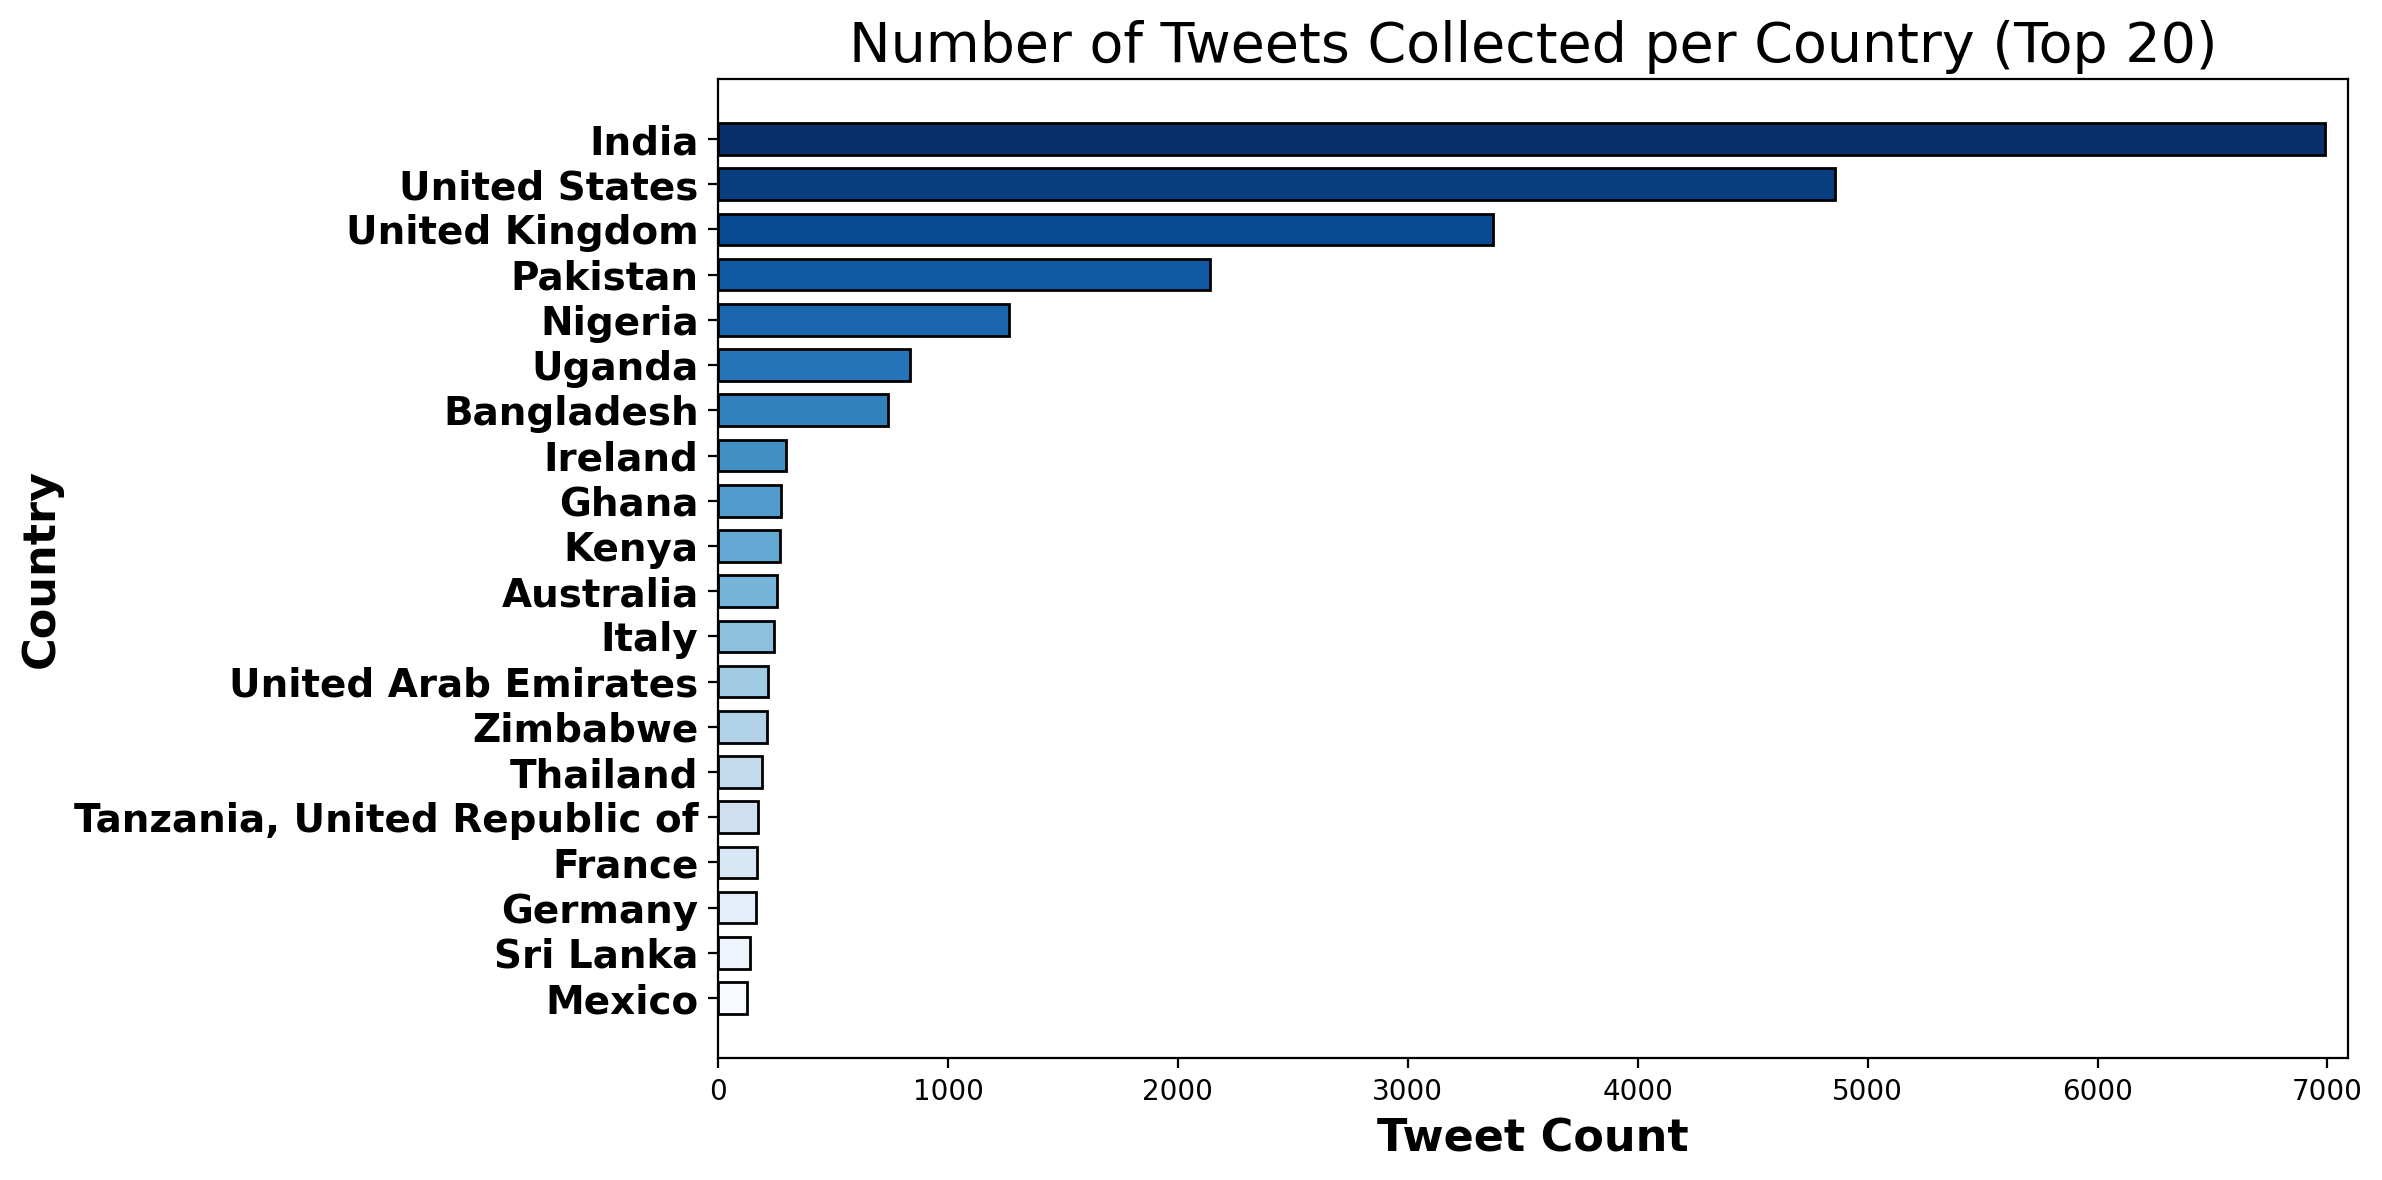

In [8]:
# setting value of number of countries i want in the plot
top_n = 20

# Select only the top n countries
top_countries = country_count_df.head(top_n)

# plot bar chart
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# setting plot colours
fig.set_facecolor('white')
ax.set_facecolor('white')

# Define a color gradient based on tweet counts
color_gradient = np.linspace(0, 1, top_n)

# data and axis labeling
bars = ax.barh(top_countries['country_name'], top_countries['tweet_count'], 
               height=0.7, edgecolor='black', color=plt.cm.get_cmap('Blues')(color_gradient)[::-1])

for label in ax.get_yticklabels():
    label.set_fontweight("bold")
    label.set_fontsize('14')
    
ax.set_xlabel('Tweet Count', fontsize=16, fontweight='bold')
ax.set_ylabel('Country', fontsize=16, fontweight='bold')
ax.set_title(f'Number of Tweets Collected per Country (Top {top_n})', 
             fontsize=20)
ax.set_xlim(right=max(top_countries['tweet_count'])+100) # adding some buffer space
ax.invert_yaxis()
plt.tight_layout()
plt.show()



#### b) Tweet distribution over time

In [9]:
import random
sample_size = 1000  # adjust this to your desired sample size
df_sample = df.sample(n=sample_size, random_state=random.seed())

fig = px.scatter(df_sample, x='date', y='region', color='region',
                 title='Tweet Distribution over Time by Region',
                 color_discrete_sequence=['#d9e6f5', '#1da1f2', '#14171a'],
                 )


fig.update_xaxes(title='Date', gridcolor='black')
fig.update_yaxes(title='Region', gridcolor='black')

fig.update_layout(
    height=400,  # set height to 600 pixels
    width=1200,  # set width to 1000 pixels
    plot_bgcolor='#EAEAEA',  # set plot background color
    paper_bgcolor='#f8f8f8',  # set plot border/background color
    margin=dict(l=20, r=20, t=60, b=20),  # adjust plot margin
    hovermode='x',  # set hover mode
)

# Add border to data lines
fig.update_traces(marker=dict(line=dict(width=1, color='black')))

import plotly.io as pio
pio.renderers.default = 'notebook_connected'
fig.show()

#### c) Average like and retweet count by country and region

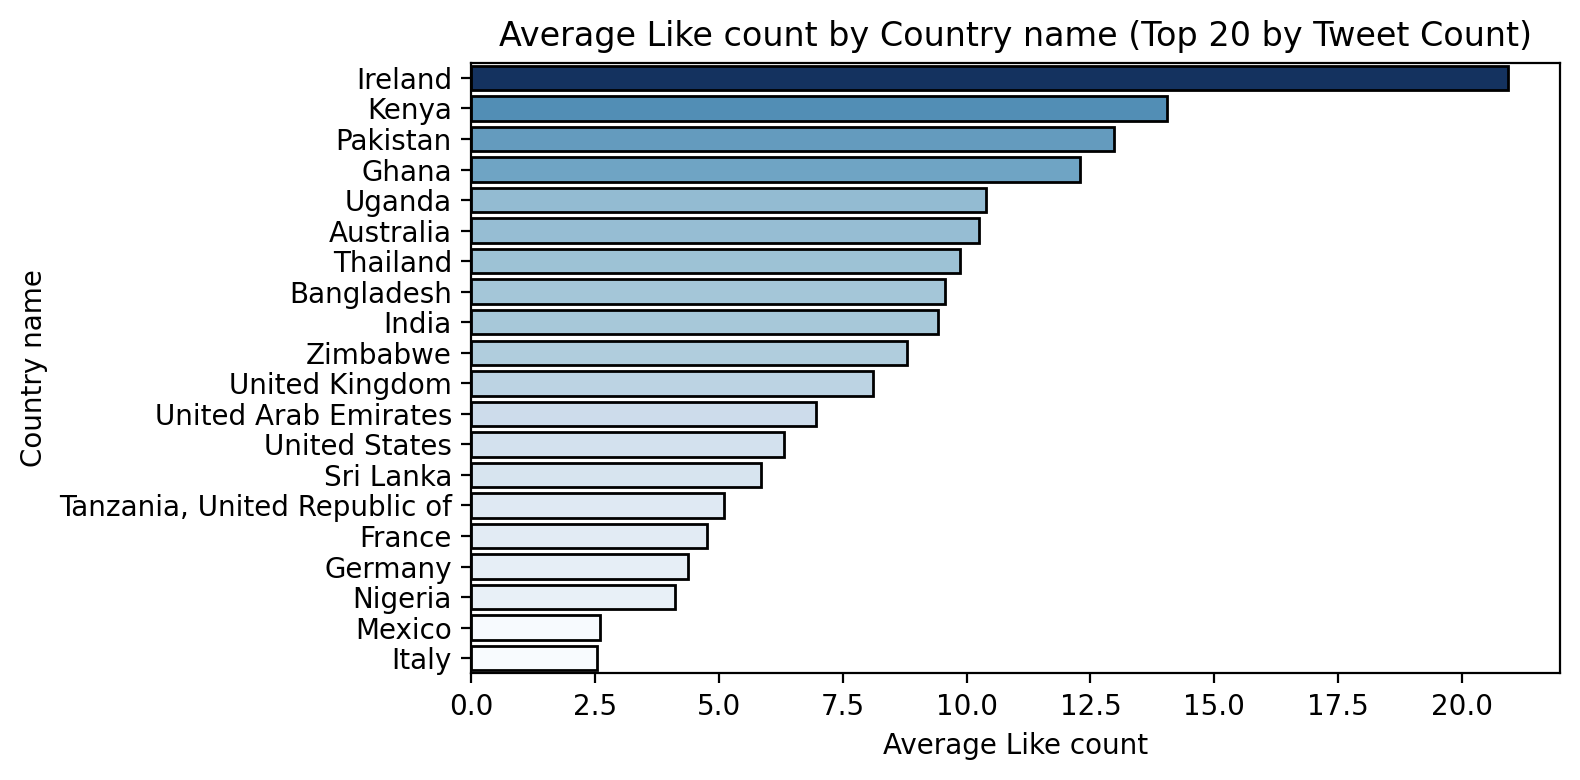

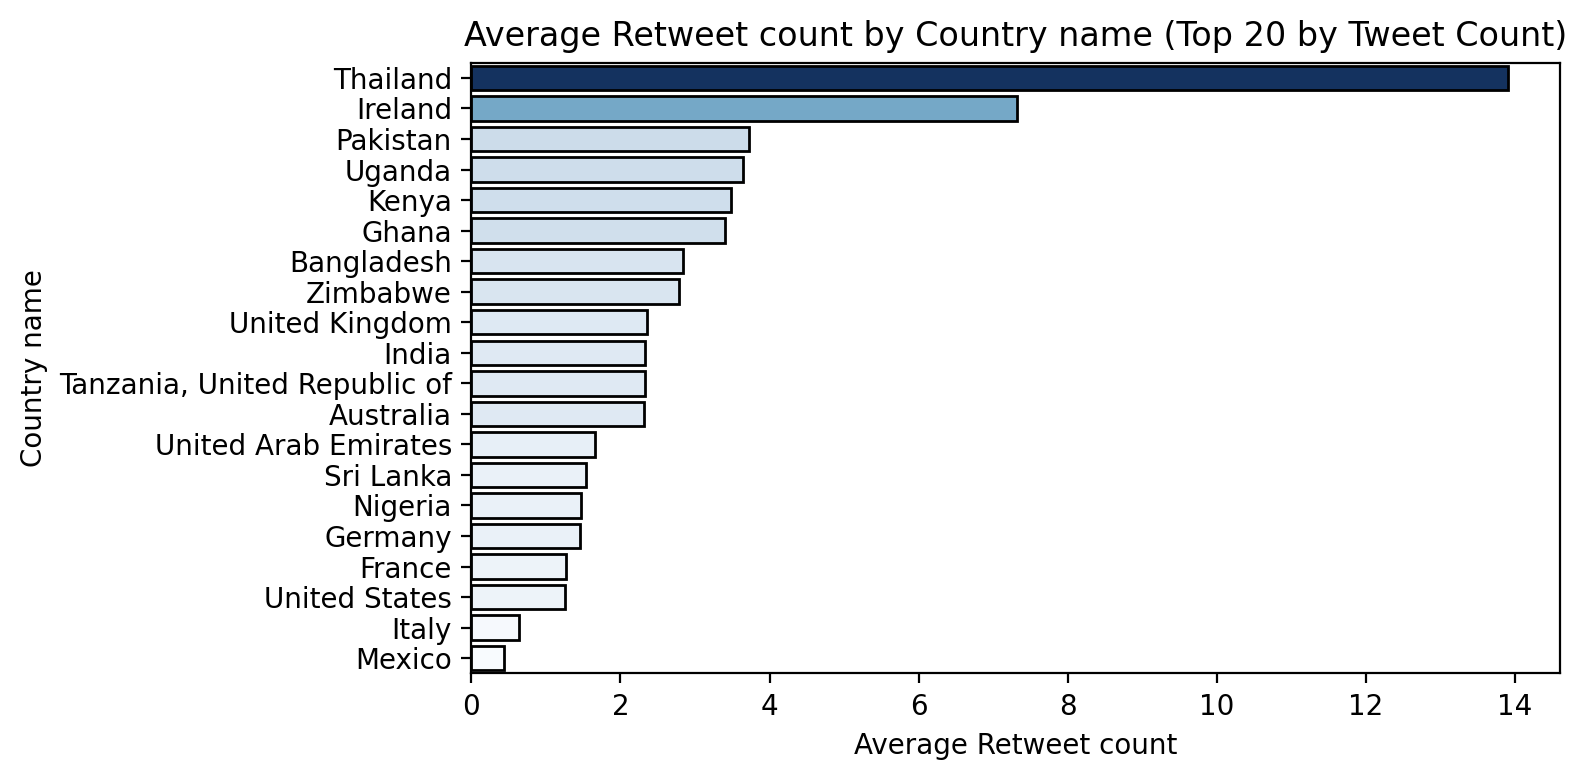

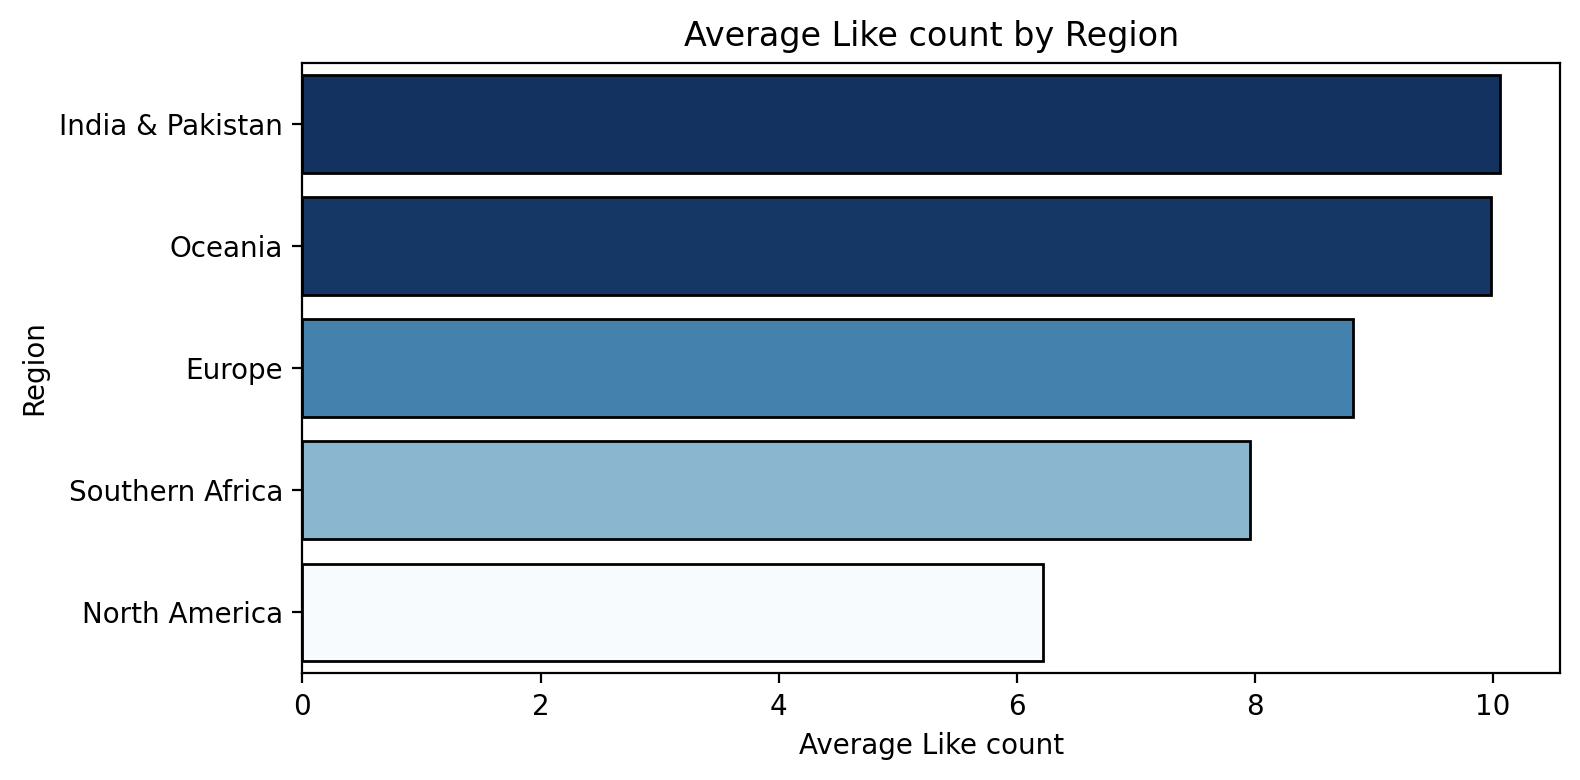

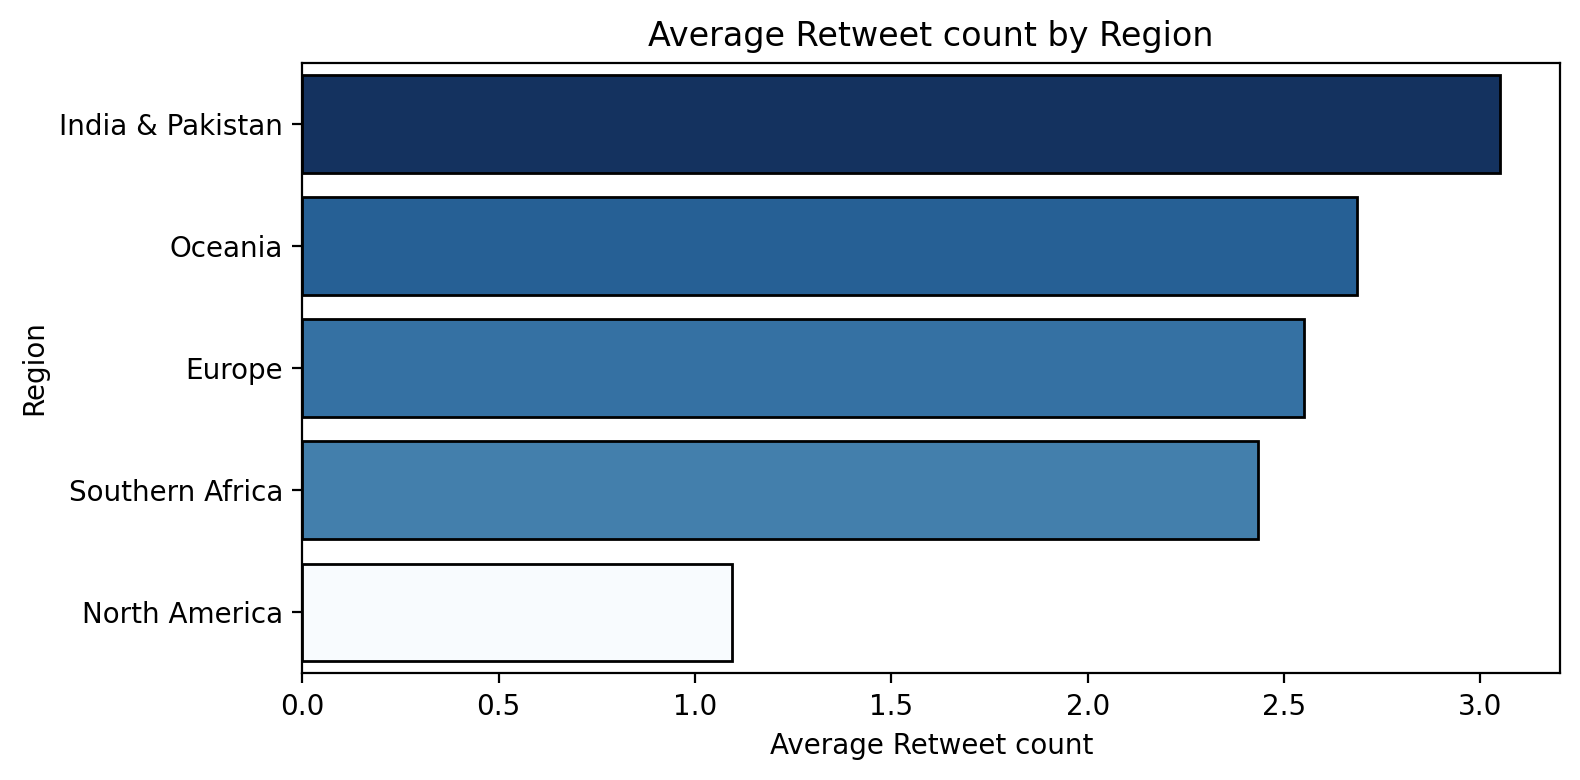

In [10]:
def plot_avg_metric_by_top_group(data, group_col, metric, top_n=20):
    # Calculate the average metric by the specified group
    avg_metric_df = data.groupby(group_col)[metric].mean().reset_index()

    # Get the top_n countries by tweet count and filter the average metric dataframe if group_col is 'country_name'
    if group_col == 'country_name':
        top_countries = data[group_col].value_counts().nlargest(top_n).index
        avg_metric_df = avg_metric_df[avg_metric_df[group_col].isin(top_countries)]

    # Sort the regions by the average metric value
    avg_metric_df = avg_metric_df.sort_values(metric, ascending=False)

    # Set color gradient
    cmap = plt.get_cmap("Blues")
    norm = plt.Normalize(avg_metric_df[metric].min(), avg_metric_df[metric].max())
    colors = cmap(norm(avg_metric_df[metric].values))

    # Create the bar plot
    plt.figure(figsize=(8, 4), dpi=200)
    sns.barplot(data=avg_metric_df, y=group_col, x=metric, palette=colors, edgecolor='black')

    # Format x-axis and y-axis labels
    plt.xlabel(f'Average {metric.replace("_", " ").capitalize()}')
    plt.ylabel(group_col.replace("_", " ").capitalize())

    # Set the title depending on the grouping column
    if group_col == 'country_name':
        title = f'Average {metric.replace("_", " ").capitalize()} by {group_col.replace("_", " ").capitalize()} (Top {top_n} by Tweet Count)'
    else:
        title = f'Average {metric.replace("_", " ").capitalize()} by {group_col.replace("_", " ").capitalize()}'

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage examples:
plot_avg_metric_by_top_group(df, 'country_name', 'like_count')
plot_avg_metric_by_top_group(df, 'country_name', 'retweet_count')
plot_avg_metric_by_top_group(df, 'region', 'like_count')
plot_avg_metric_by_top_group(df, 'region', 'retweet_count')


#### d) Visualising top users by tweet count (usernames with 25 or more tweets)

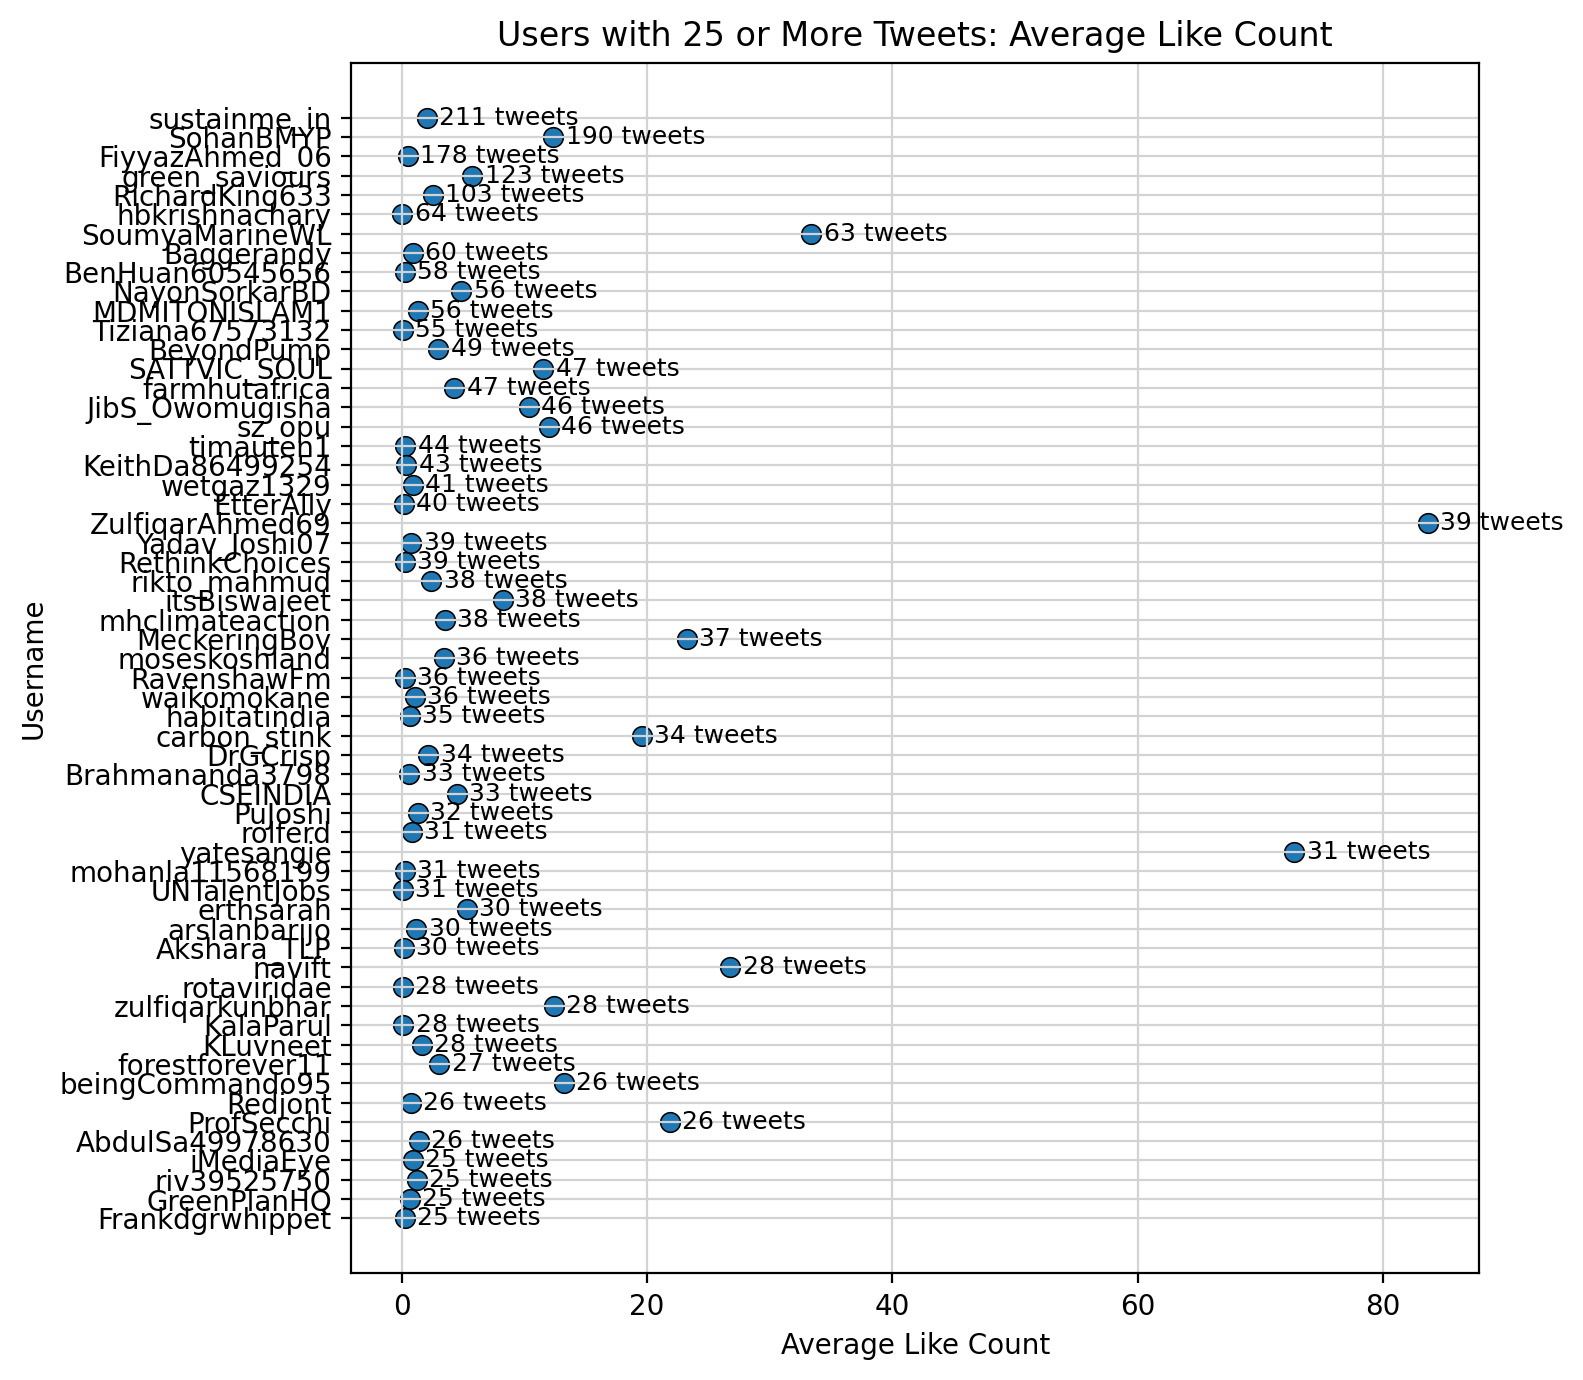

In [11]:
# Filter users with 10 or more tweets
user_tweets = df['username'].value_counts()
user_tweets_10_or_more = user_tweets[user_tweets >= 25].index

# Filter original dataframe to keep users 10=< tweets and calculate avg like count
df_filtered = df[df['username'].isin(user_tweets_10_or_more)]
user_metrics = df_filtered.groupby('username')[['like_count']].mean().reset_index()

# Add tweets count of each user to user_metrics df and sort by tweet count
user_metrics['tweet_count'] = user_metrics['username'].map(user_tweets)
user_metrics.sort_values('tweet_count', ascending=False, inplace=True)

# define a blue color palette
blue_palette = sns.color_palette('Blues', n_colors=len(user_metrics))

plt.figure(figsize=(8, 7), dpi=200)

for _, row in user_metrics.iterrows():
    plt.text(row['like_count'] + 1, row['username'], f"{row['tweet_count']} tweets", 
             verticalalignment='center', color='black', fontsize=9)
    
sns.scatterplot(data=user_metrics, x='like_count', y='username', marker='o', 
                s=50, edgecolor='black')

plt.xlabel('Average Like Count')
plt.ylabel('Username')
plt.title('Users with 25 or More Tweets: Average Like Count')
plt.tight_layout()

# Add grid lines
plt.grid(axis='both', color='lightgrey')



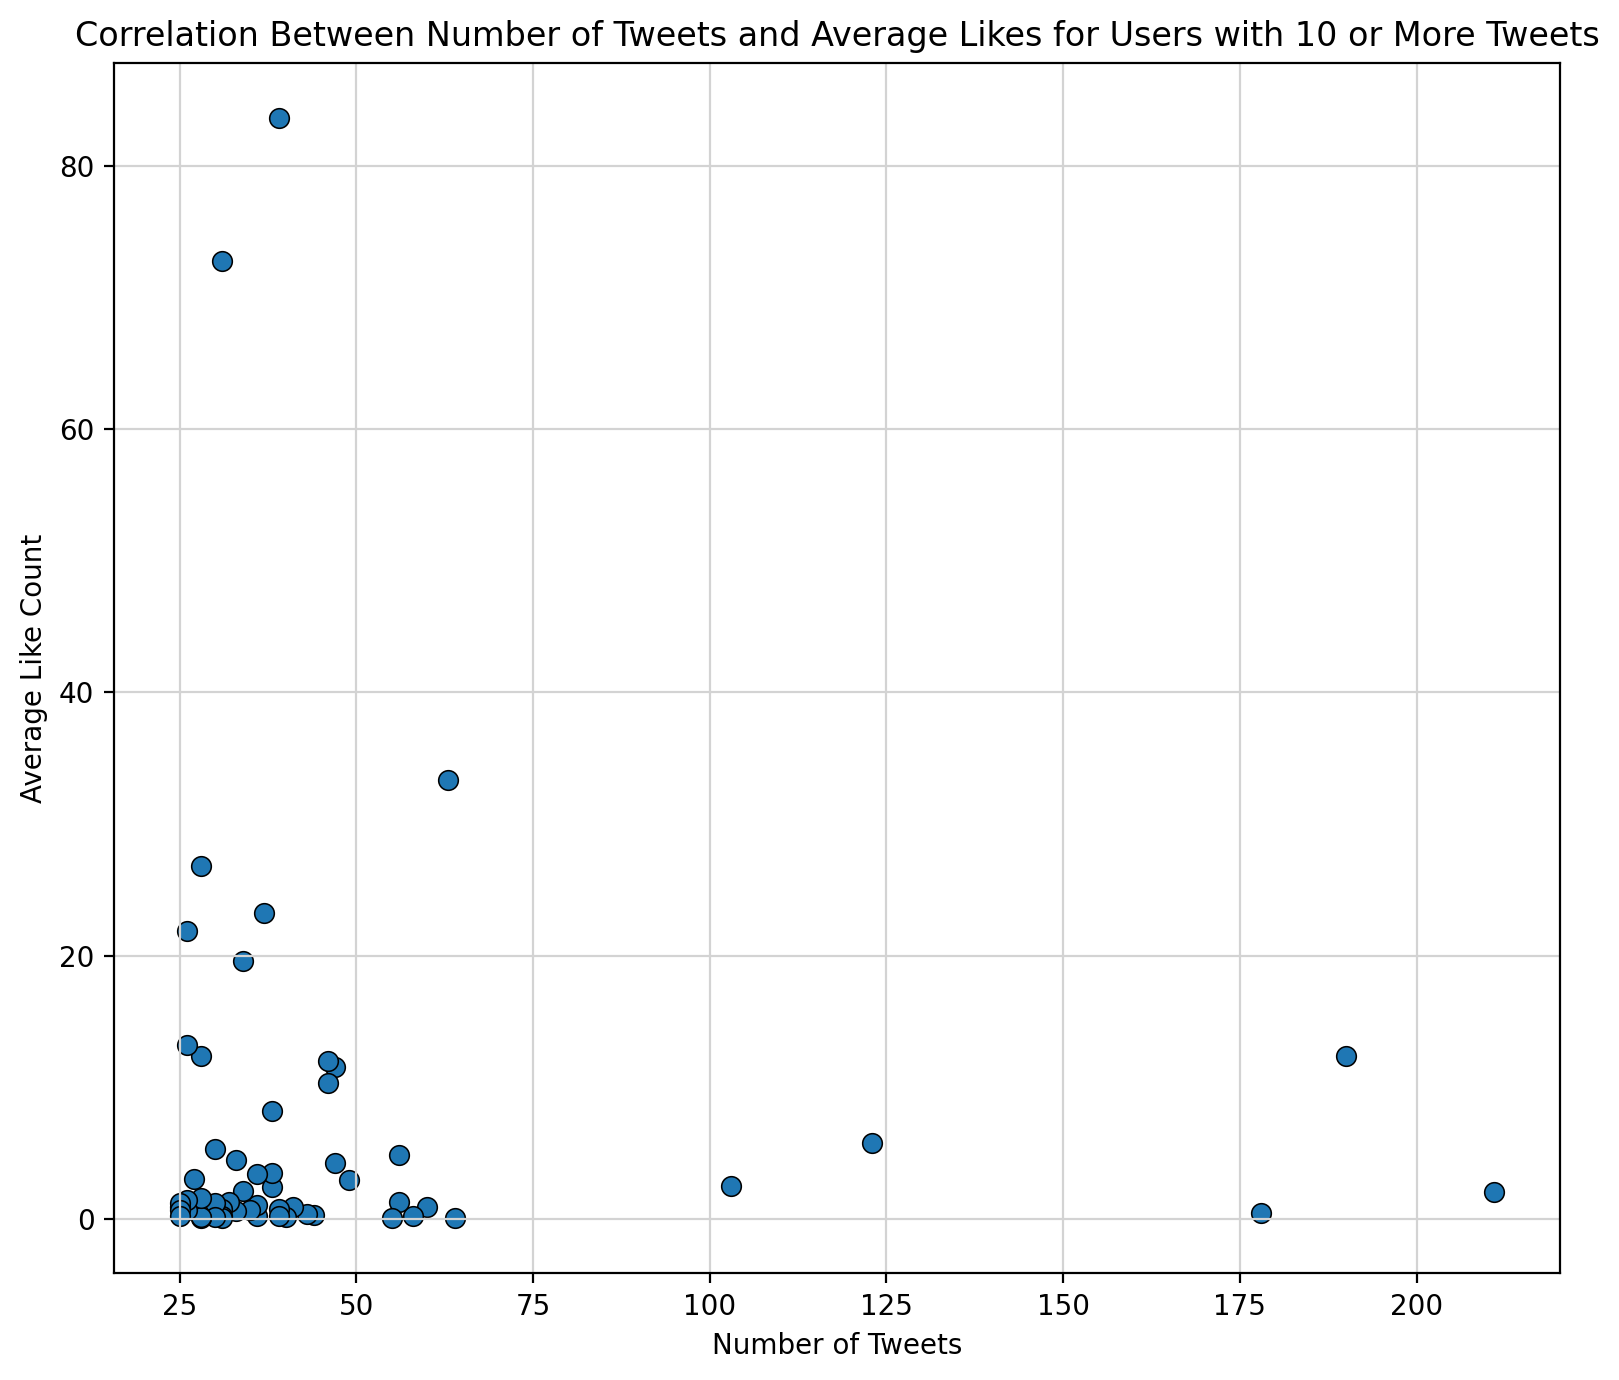

In [12]:
# Filter users with 10 or more tweets
user_tweets = df['username'].value_counts()
user_tweets_10_or_more = user_tweets[user_tweets >= 25].index

# Filter original dataframe to keep users with 10=< tweets and calculate avg like count
df_filtered = df[df['username'].isin(user_tweets_10_or_more)]
user_metrics = df_filtered.groupby('username')[['like_count']].mean().reset_index()

# Add tweets count of each user to user_metrics df and sort by tweet count
user_metrics['tweet_count'] = user_metrics['username'].map(user_tweets)
user_metrics.sort_values('tweet_count', ascending=False, inplace=True)

user_metrics.rename(columns={'like_count': 'average_likes'}, inplace=True)

plt.figure(figsize=(8, 7), dpi=200)
sns.scatterplot(data=user_metrics, x='tweet_count', y='average_likes', marker='o', 
                s=50, edgecolor='black')

plt.xlabel('Number of Tweets')
plt.ylabel('Average Like Count')
plt.title('Correlation Between Number of Tweets and Average Likes for Users with 10 or More Tweets')
plt.tight_layout()

# Add grid lines
plt.grid(axis='both', color='lightgrey')

plt.show()

#### e) Tweet length distribution

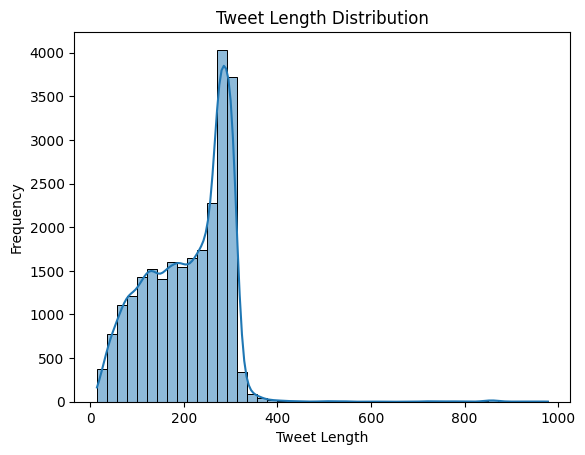

In [13]:
df['tweet_length'] = df['content'].apply(len)
sns.histplot(data=df, x='tweet_length', bins=45, kde=True)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweet Length Distribution')
plt.show()

#### f) Hashtags and Mentions Frequency Distribution

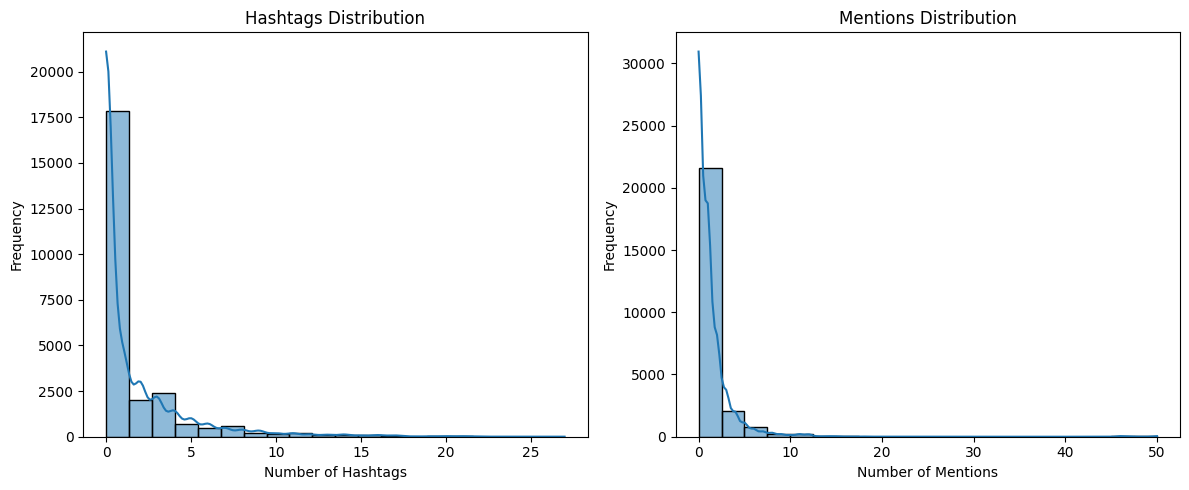

In [14]:
df['hashtags_count'] = df['content'].apply(lambda x: x.count('#'))
df['mentions_count'] = df['content'].apply(lambda x: x.count('@'))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='hashtags_count', bins=20, kde=True, ax=axes[0])
sns.histplot(data=df, x='mentions_count', bins=20, kde=True, ax=axes[1])

axes[0].set_xlabel('Number of Hashtags')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hashtags Distribution')

axes[1].set_xlabel('Number of Mentions')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mentions Distribution')

plt.tight_layout()
plt.show()


#### g) top Hashtags and Mentions

In [15]:
def get_hashtags_and_mentions(content):
    words = content.split()
    hashtags = [word for word in words if word.startswith('#')]
    mentions = [word for word in words if word.startswith('@')]
    return hashtags, mentions

hashtags = []
mentions = []

for _, row in df.iterrows():
    tweet_hashtags, tweet_mentions = get_hashtags_and_mentions(row['content'])
    hashtags.extend(tweet_hashtags)
    mentions.extend(tweet_mentions)

hashtags_counter = collections.Counter(hashtags)
mentions_counter = collections.Counter(mentions)

print("Top 10 hashtags:", hashtags_counter.most_common(10))
print("Top 10 mentions:", mentions_counter.most_common(10))


Top 10 hashtags: [('#climatechange', 2837), ('#ClimateChange', 1511), ('#climate', 634), ('#ClimateCrisis', 612), ('#ClimateAction', 545), ('#COP27', 518), ('#ClimateEmergency', 504), ('#sustainability', 337), ('#SaveSoil', 314), ('#ClimateActionNow', 235)]
Top 10 mentions: [('@GretaThunberg', 168), ('@UN', 167), ('@', 167), ('@UNFCCC', 162), ('@POTUS', 136), ('@cpsavesoil', 114), ('@COP27P', 108), ('@narendramodi', 108), ('@SadhguruJV', 104), ('@moefcc', 104)]


In [16]:
def plot_top_items(counter, title, xlabel, ylabel):
    items, counts = zip(*counter.most_common(10)[::-1])
    data = {ylabel: items, xlabel: counts}
    fig = px.bar(data, x=xlabel, y=ylabel, orientation='h', text=xlabel)
    fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
    fig.update_layout(title=title, xaxis_title=xlabel, yaxis_title=ylabel)
    fig.show()

plot_top_items(hashtags_counter, "Top 10 Hashtags", "Count", "Hashtag")
plot_top_items(mentions_counter, "Top 10 Mentions", "Count", "Mention")


#### h) Sentiment analysis

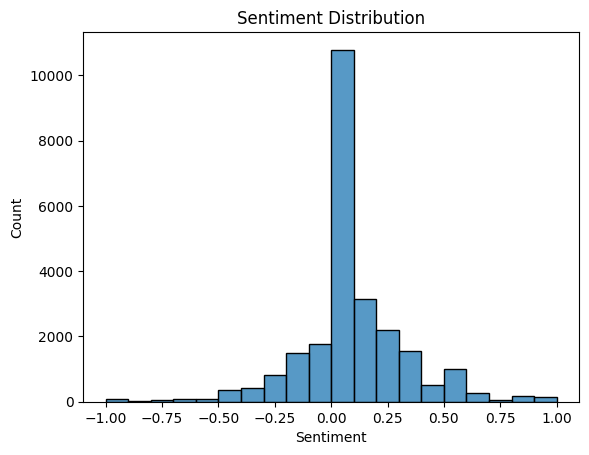

In [17]:
df['sentiment'] = df['content'].apply(lambda text: TextBlob(text).sentiment.polarity)
sns.histplot(data=df, x='sentiment', bins=20)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

it seems that the majority of tweets have a neutral sentiment score (close to 0.00), while fewer tweets exhibit strong negative or positive sentiments (closer to -1.00 or 1.00, respectively).

## 3. Text data pre-processing

#### a) Convert to lowercase text
converting all of the text to lowercase to make sure consistency throughout and eliminate case sensitivity issues udring analysis

In [18]:
df['cleaned_content'] = df['content'].str.lower()

#### b) Removing Irrelevant elements and special characters.
Removing URLs, mentions and hashtags as these elements are noisy and dont add much too analysis, removing using regular expressions.

In [19]:
import re

def remove_urls_mentions_hashtags(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'#\w+', '', text) 
    return text

df['cleaned_content'] = df['cleaned_content'].apply(remove_urls_mentions_hashtags)

Also removing special characters, numbers and emojis, as this will be purely text analysis

In [20]:
def remove_special_chars(text):
    return re.sub(r'[^a-z\s]', '', text)

df['cleaned_content'] = df['cleaned_content'].apply(remove_special_chars)

#### c) Tokenization
Splitting up text into individual words (tokens) to allow natural language processing

In [21]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

df['tokens'] = df['cleaned_content'].apply(word_tokenize)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


#### d) Removing stopwords

In [22]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


#### e) Lemmatize and Stem

In [23]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['tokens'] = df['tokens'].apply(lemmatize)

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [24]:
df.head()

Unnamed: 0       date                                            content  \
0           0 2023-03-24  @kajunjon I’m waiting for some “climate expert...   
1           1 2023-03-24  @andrewlukenbach It's not global warming anymo...   
2           2 2023-03-24  Watching their cherished wilderness succumb to...   
3           3 2023-03-24  And maybe a couple brownies. \nThe #Obamacare ...   
4           4 2023-03-24  Look up the facts- If the government supports ...   

         username  like_count  retweet_count         region   country_name  \
0      droachnola           0            0.0  North America  United States   
1  hammtweezy2192           1            0.0  North America  United States   
2  sashadigiulian           4            4.0  North America  United States   
3  MandyintheWest           0            0.0  North America  United States   
4        lipmannj           0            0.0  North America  United States   

   tweet_length  hashtags_count  mentions_count  sentiment  \
0           123               0               1   0.000000   
1           121               0               1   0.200000   
2           186               0               0   0.000000   
3           304               2               0   0.271429   
4           296               0               0  -0.125000   

                                     cleaned_content  \
0   im waiting for some climate expert to tell me...   
1   its not global warming anymore because that d...   
2  watching their cherished wilderness succumb to...   
3  and maybe a couple brownies \nthe  lies are al...   
4  look up the facts if the government supports t...   

                                              tokens  
0  [im, waiting, climate, expert, tell, actual, c...  
1  [global, warming, anymore, doesnt, fit, narrat...  
2  [watching, cherished, wilderness, succumb, eff...  
3  [maybe, couple, brownie, lie, twitter, one, wo...  
4  [look, fact, government, support, scientist, g...

In [25]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
df.head()

date                                            content  \
0 2023-03-24  @kajunjon I’m waiting for some “climate expert...   
1 2023-03-24  @andrewlukenbach It's not global warming anymo...   
2 2023-03-24  Watching their cherished wilderness succumb to...   
3 2023-03-24  And maybe a couple brownies. \nThe #Obamacare ...   
4 2023-03-24  Look up the facts- If the government supports ...   

         username  like_count  retweet_count         region   country_name  \
0      droachnola           0            0.0  North America  United States   
1  hammtweezy2192           1            0.0  North America  United States   
2  sashadigiulian           4            4.0  North America  United States   
3  MandyintheWest           0            0.0  North America  United States   
4        lipmannj           0            0.0  North America  United States   

   tweet_length  hashtags_count  mentions_count  sentiment  \
0           123               0               1   0.000000   
1           121               0               1   0.200000   
2           186               0               0   0.000000   
3           304               2               0   0.271429   
4           296               0               0  -0.125000   

                                     cleaned_content  \
0   im waiting for some climate expert to tell me...   
1   its not global warming anymore because that d...   
2  watching their cherished wilderness succumb to...   
3  and maybe a couple brownies \nthe  lies are al...   
4  look up the facts if the government supports t...   

                                              tokens  
0  [im, waiting, climate, expert, tell, actual, c...  
1  [global, warming, anymore, doesnt, fit, narrat...  
2  [watching, cherished, wilderness, succumb, eff...  
3  [maybe, couple, brownie, lie, twitter, one, wo...  
4  [look, fact, government, support, scientist, g...

## 4. NLP Analysis
#### 1. NLTK sentiment analysis

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_content'].apply(lambda text: sia.polarity_scores(text)['compound'])

#### Analysing sentiment score of cleaned content across groups
* Top 20 Countries with Highest sentiment:

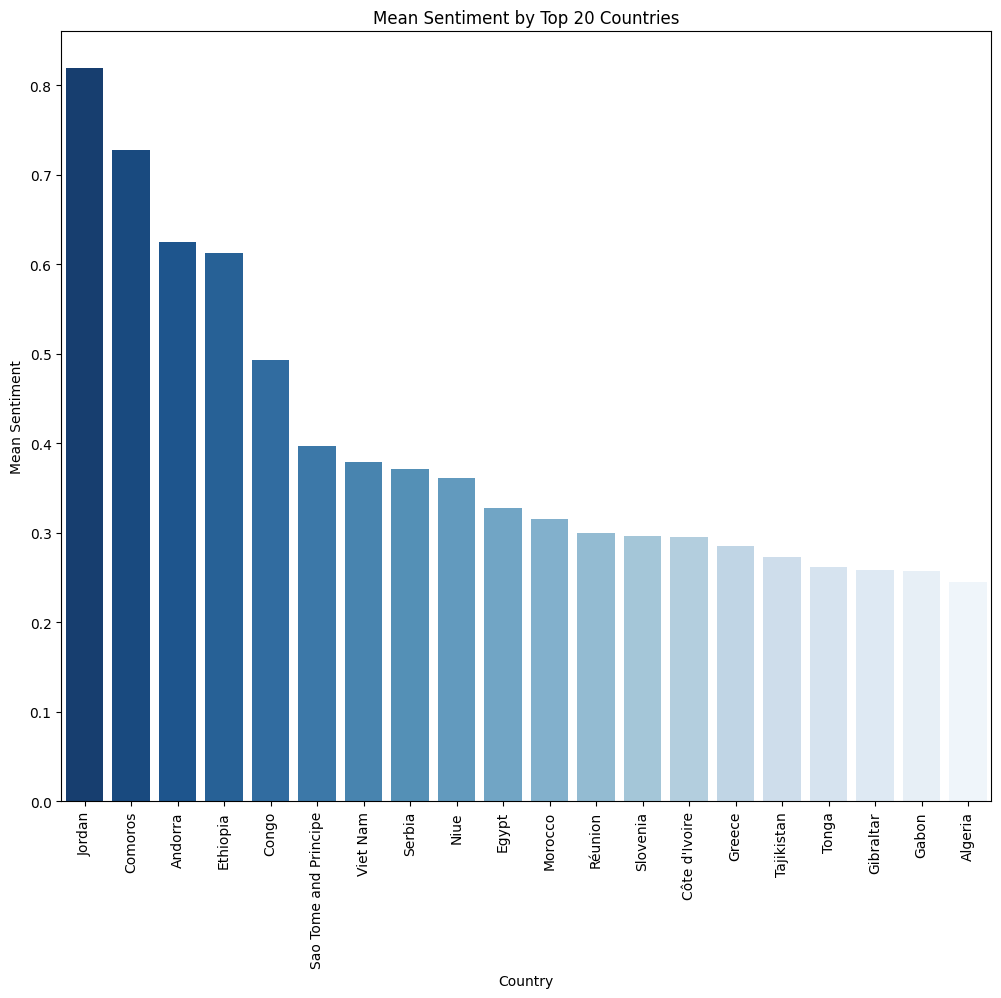

In [28]:
mean_sentiment = df.groupby('country_name')['sentiment'].mean().reset_index()

# Sort by mean sentiment value and get the top 20 countries
top_countries = mean_sentiment.sort_values('sentiment', ascending=False).head(20)


plt.figure(figsize=(12,10))

colors = sns.color_palette("Blues_r", n_colors=len(top_countries))

sns.barplot(x='country_name', y='sentiment', data=top_countries, palette=colors)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment by Top 20 Countries')
plt.show()

* Mean sentiment of lowest 20 countries

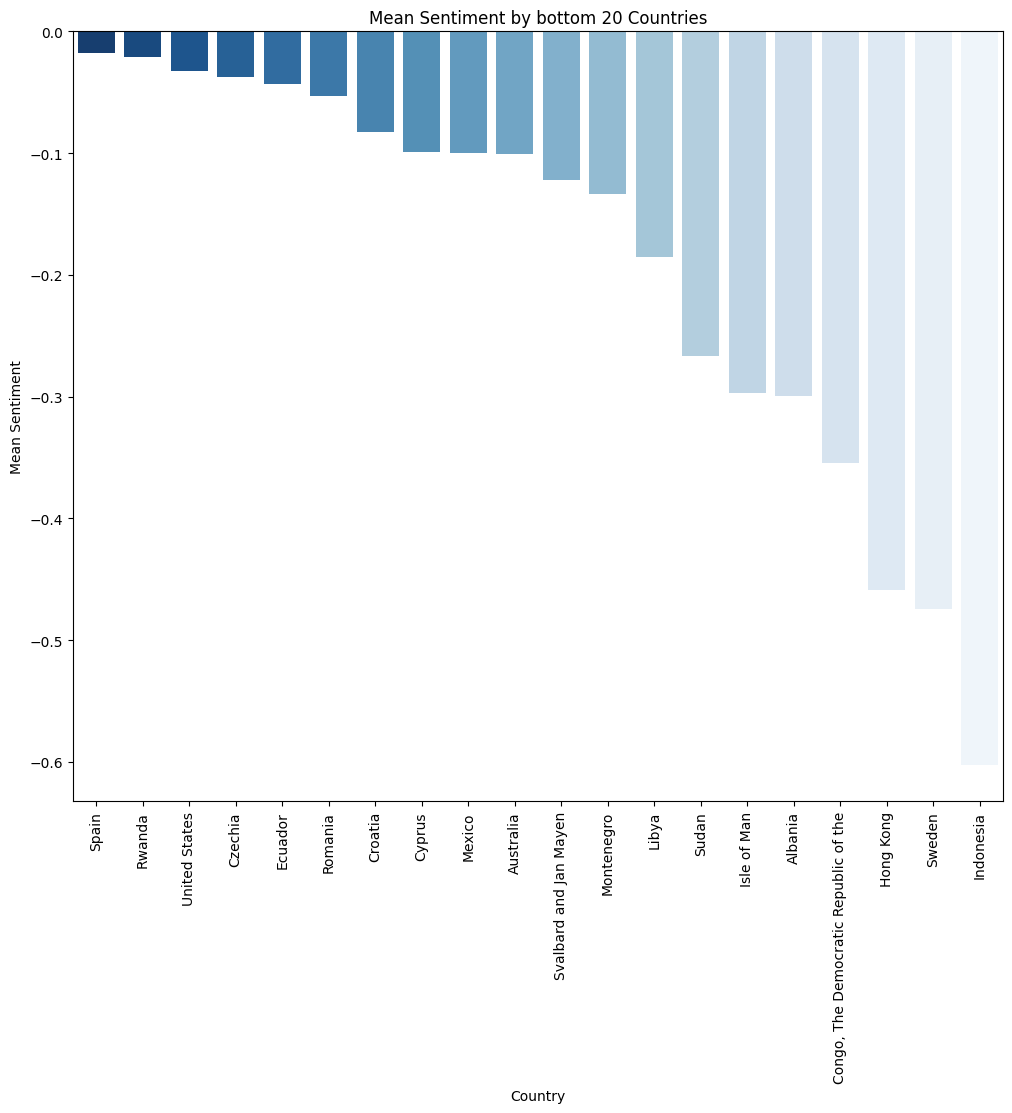

In [29]:
mean_sentiment = df.groupby('country_name')['sentiment'].mean().reset_index()

# sort by mean sentiment value and get the top 20 countries
top_countries = mean_sentiment.sort_values('sentiment', ascending=False).tail(20)

plt.figure(figsize=(12,10))

colors = sns.color_palette("Blues_r", n_colors=len(top_countries))

sns.barplot(x='country_name', y='sentiment', data=top_countries, palette=colors)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment by bottom 20 Countries')
plt.show()

* Mean sentiment of top 30 countries by number of tweets in dataset

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_1428/2702588013.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



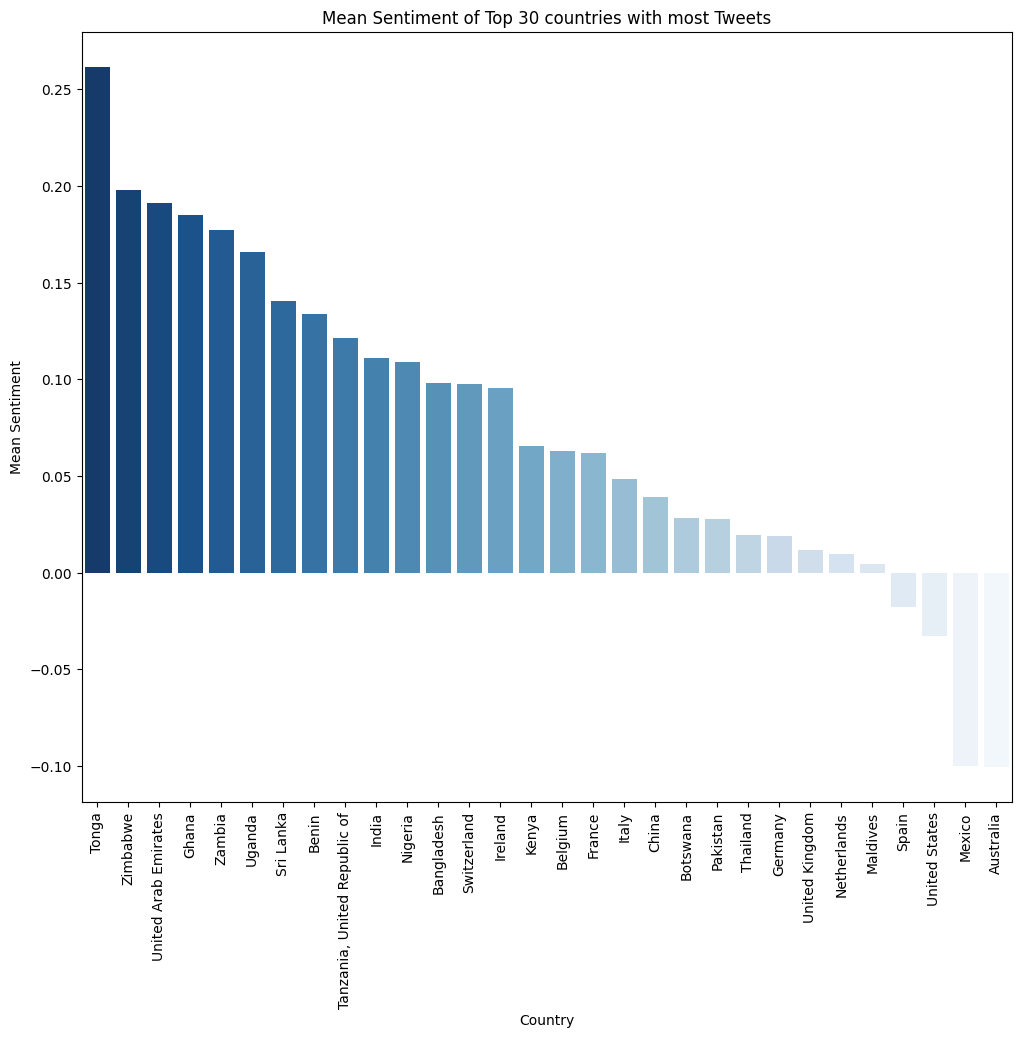

In [30]:
# Get the top 20 countries by tweet count
top_countries = df['country_name'].value_counts().head(30)

# Filter the DataFrame to only include tweets from the top countries
df_top = df[df['country_name'].isin(top_countries.index)]

# Compute the sentiment scores for the top countries
sia = SentimentIntensityAnalyzer()
df_top['sentiment'] = df_top['cleaned_content'].apply(lambda text: sia.polarity_scores(text)['compound'])
mean_sentiment = df_top.groupby('country_name')['sentiment'].mean().reset_index()

# Sort by mean sentiment value and get the top 20 countries
top_countries_sentiment = mean_sentiment.sort_values('sentiment', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='country_name', y='sentiment', data=top_countries_sentiment, palette='Blues_r')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment of Top 30 countries with most Tweets')
plt.show()

In [31]:
mean_sentiment.sort_values('sentiment', ascending=False).head(30)

country_name  sentiment
23                         Tonga   0.261554
29                      Zimbabwe   0.197686
25          United Arab Emirates   0.191385
8                          Ghana   0.185197
28                        Zambia   0.177263
24                        Uganda   0.165693
19                     Sri Lanka   0.140579
3                          Benin   0.133846
21  Tanzania, United Republic of   0.121322
9                          India   0.111155
16                       Nigeria   0.109086
1                     Bangladesh   0.097991
20                   Switzerland   0.097545
10                       Ireland   0.095514
12                         Kenya   0.065610
2                        Belgium   0.062895
6                         France   0.061985
11                         Italy   0.048481
5                          China   0.039244
4                       Botswana   0.028015
17                      Pakistan   0.027790
22                      Thailand   0.019241
7                        Germany   0.018776
26                United Kingdom   0.011752
15                   Netherlands   0.009794
13                      Maldives   0.004204
18                         Spain  -0.017719
27                 United States  -0.032823
14                        Mexico  -0.099791
0                      Australia  -0.100440

##### Plotting mean sentiment by region

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_1428/2843491506.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



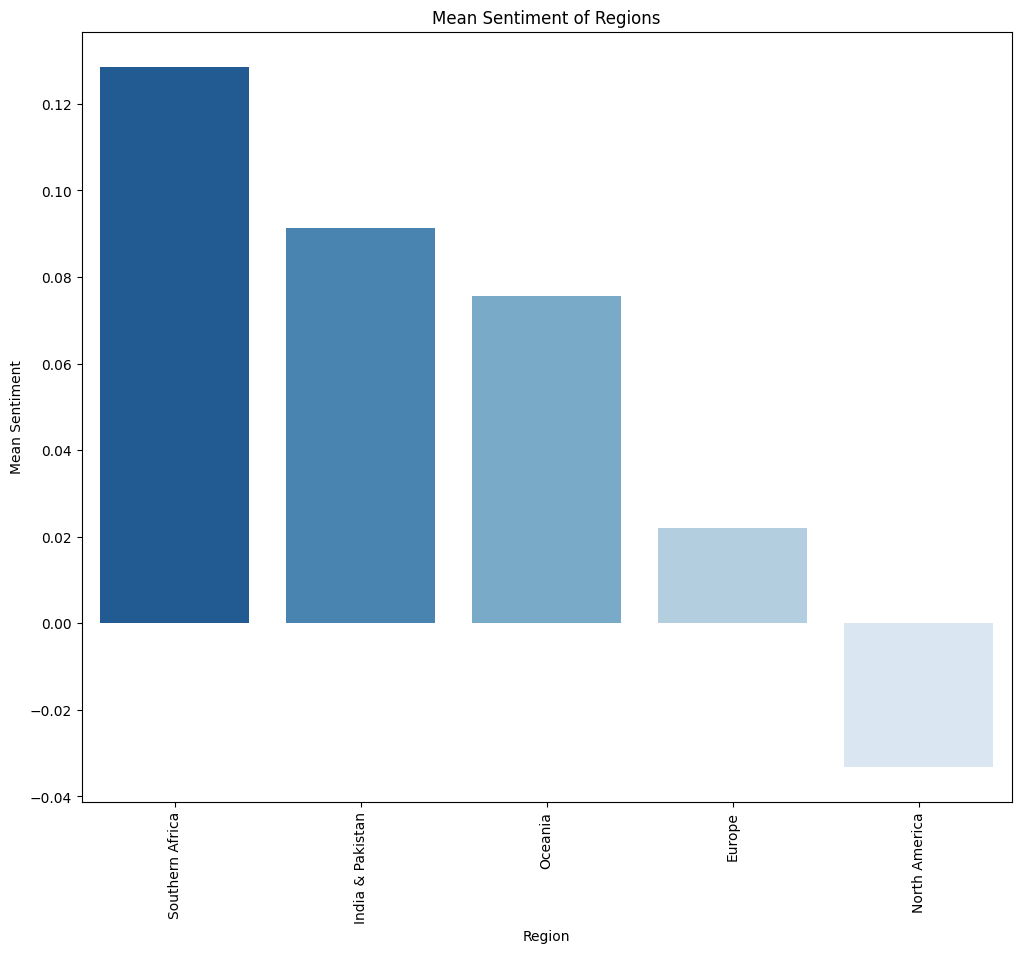

In [32]:
df_top['sentiment'] = df_top['cleaned_content'].apply(lambda text: sia.polarity_scores(text)['compound'])
mean_sentiment = df_top.groupby('region')['sentiment'].mean().reset_index()

# Sort by mean sentiment value and get the top 20 countries
region_sentiment = mean_sentiment.sort_values('sentiment', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='region', y='sentiment', data=region_sentiment, palette='Blues_r')
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment of Regions')
plt.show()

In [33]:
mean_sentiment.sort_values('sentiment', ascending=False)

region  sentiment
4   Southern Africa   0.128586
1  India & Pakistan   0.091431
3           Oceania   0.075595
0            Europe   0.022068
2     North America  -0.033139

* Mean Sentiment over time

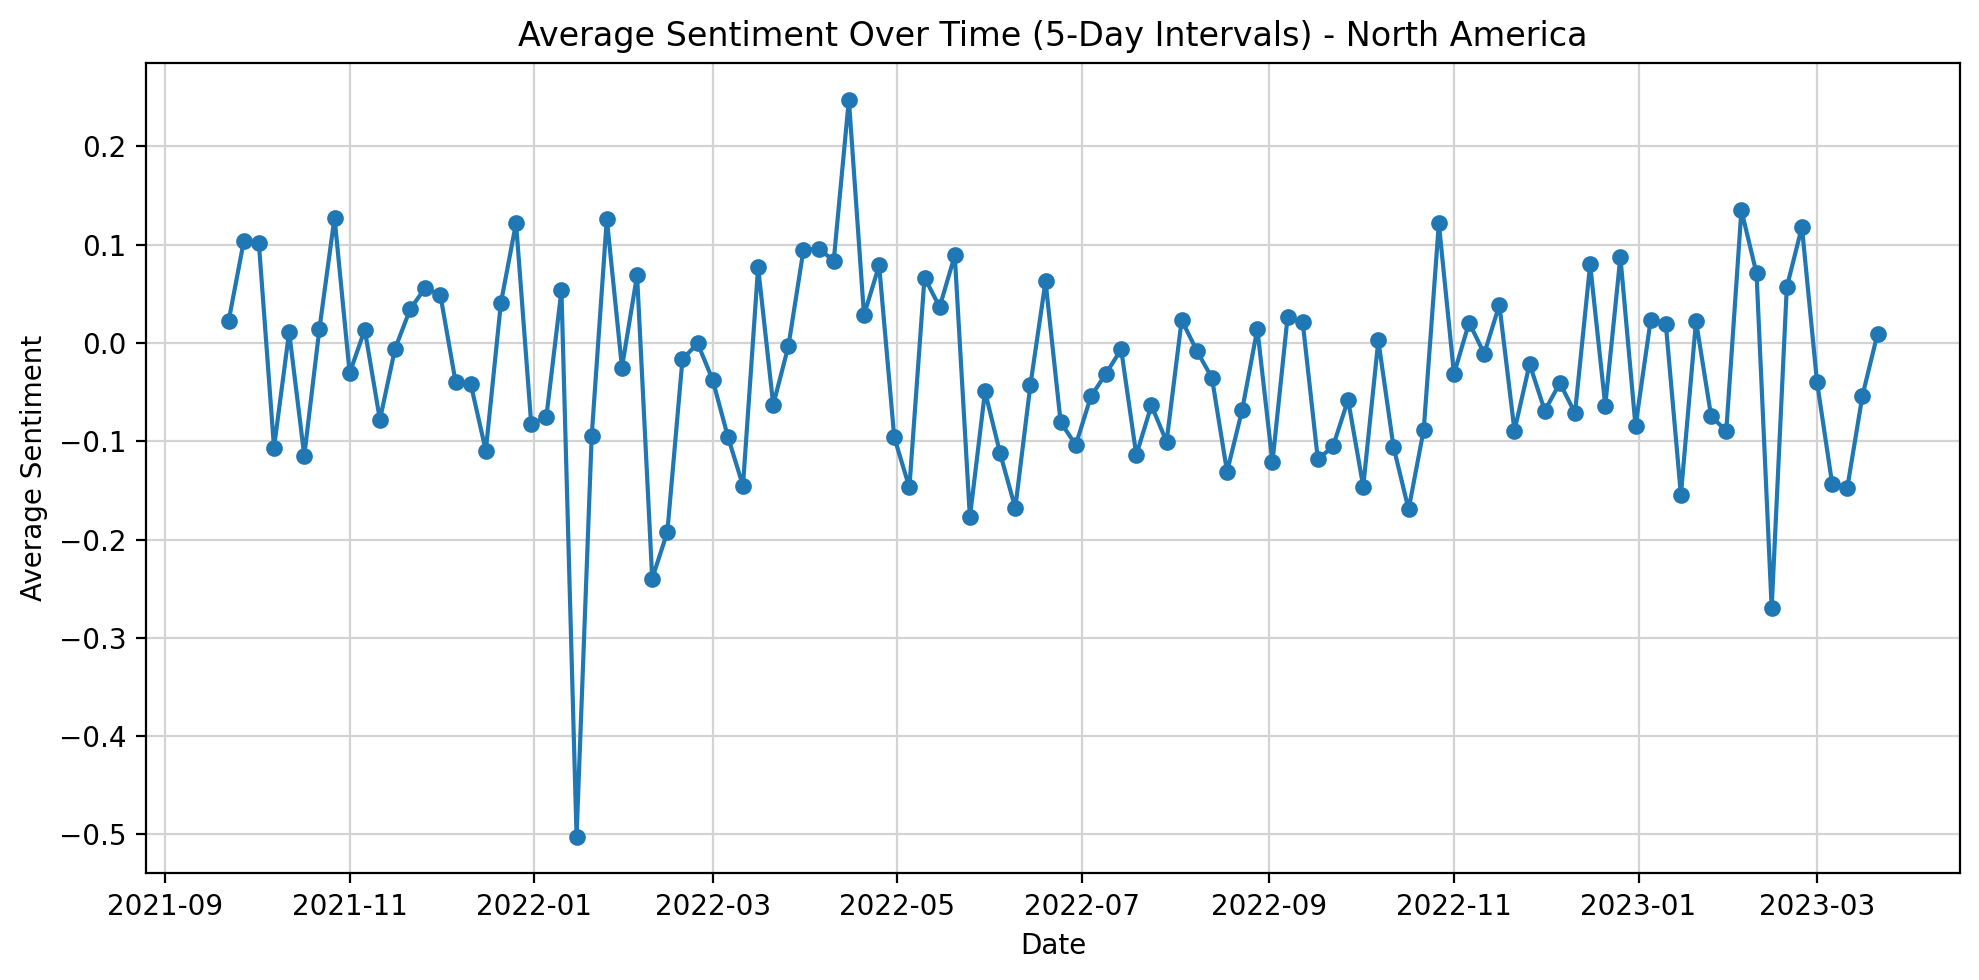

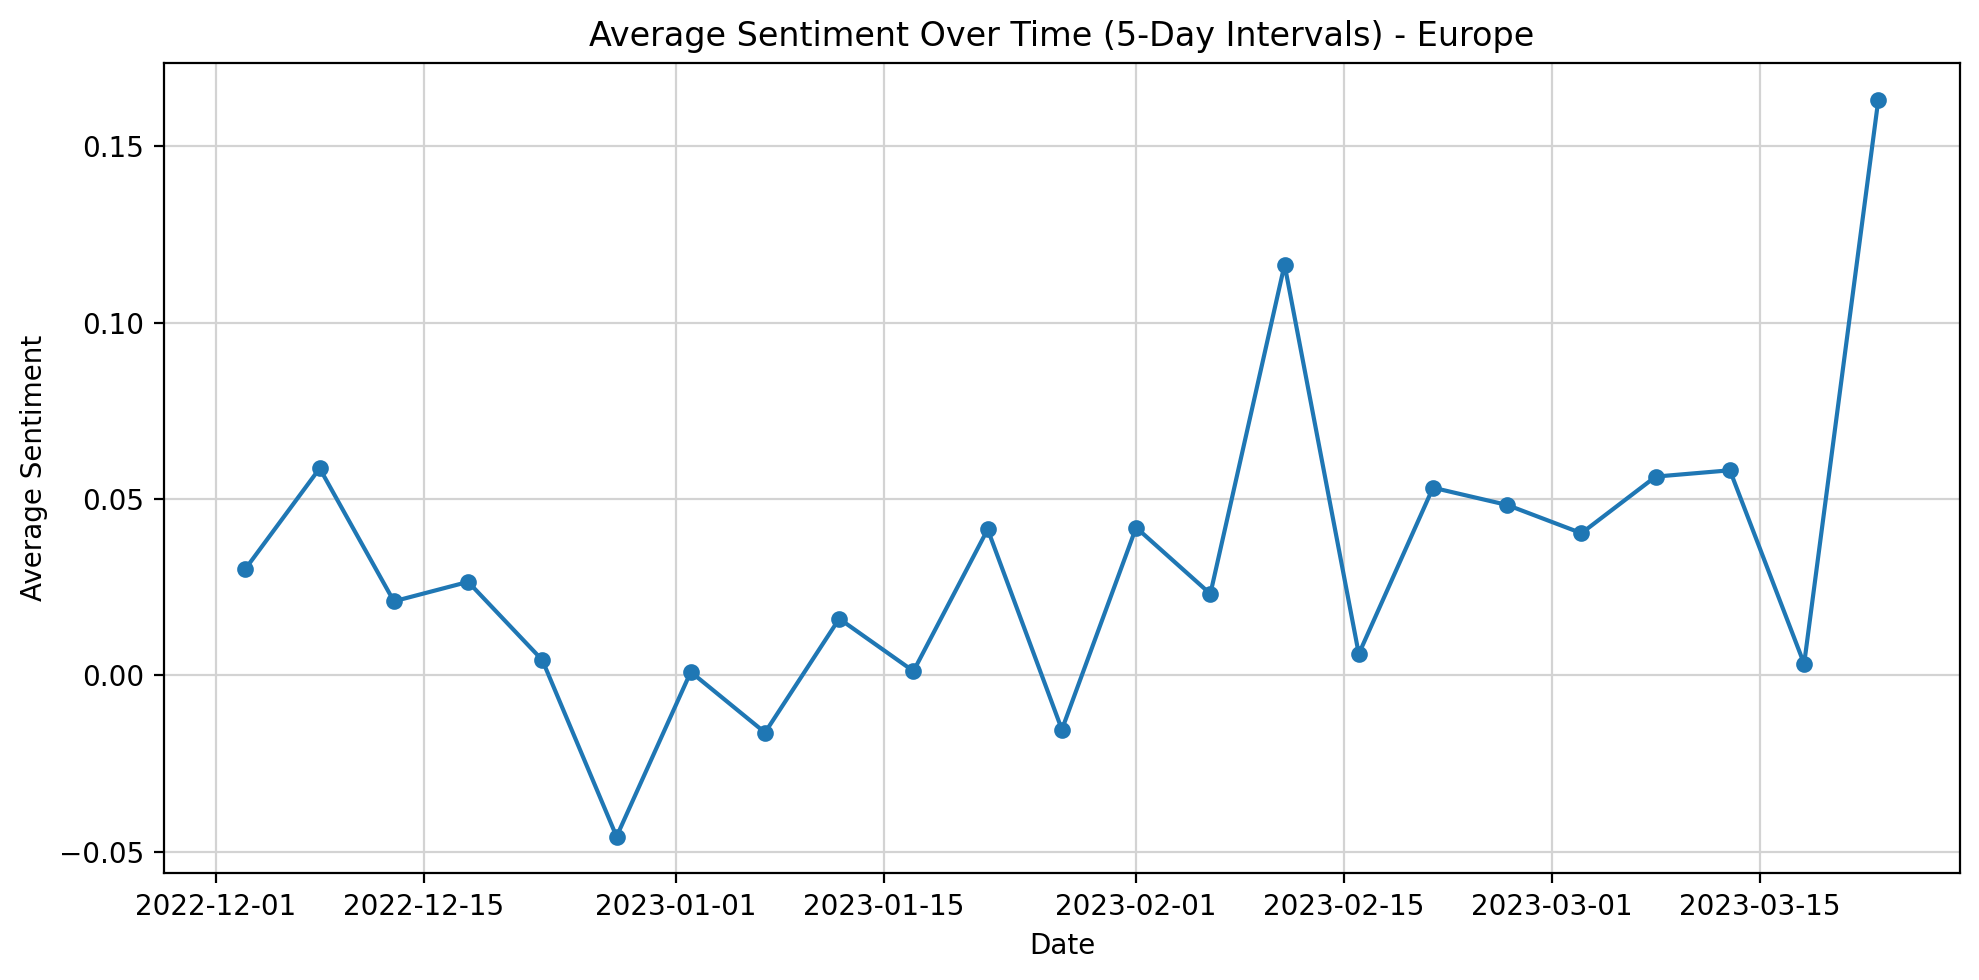

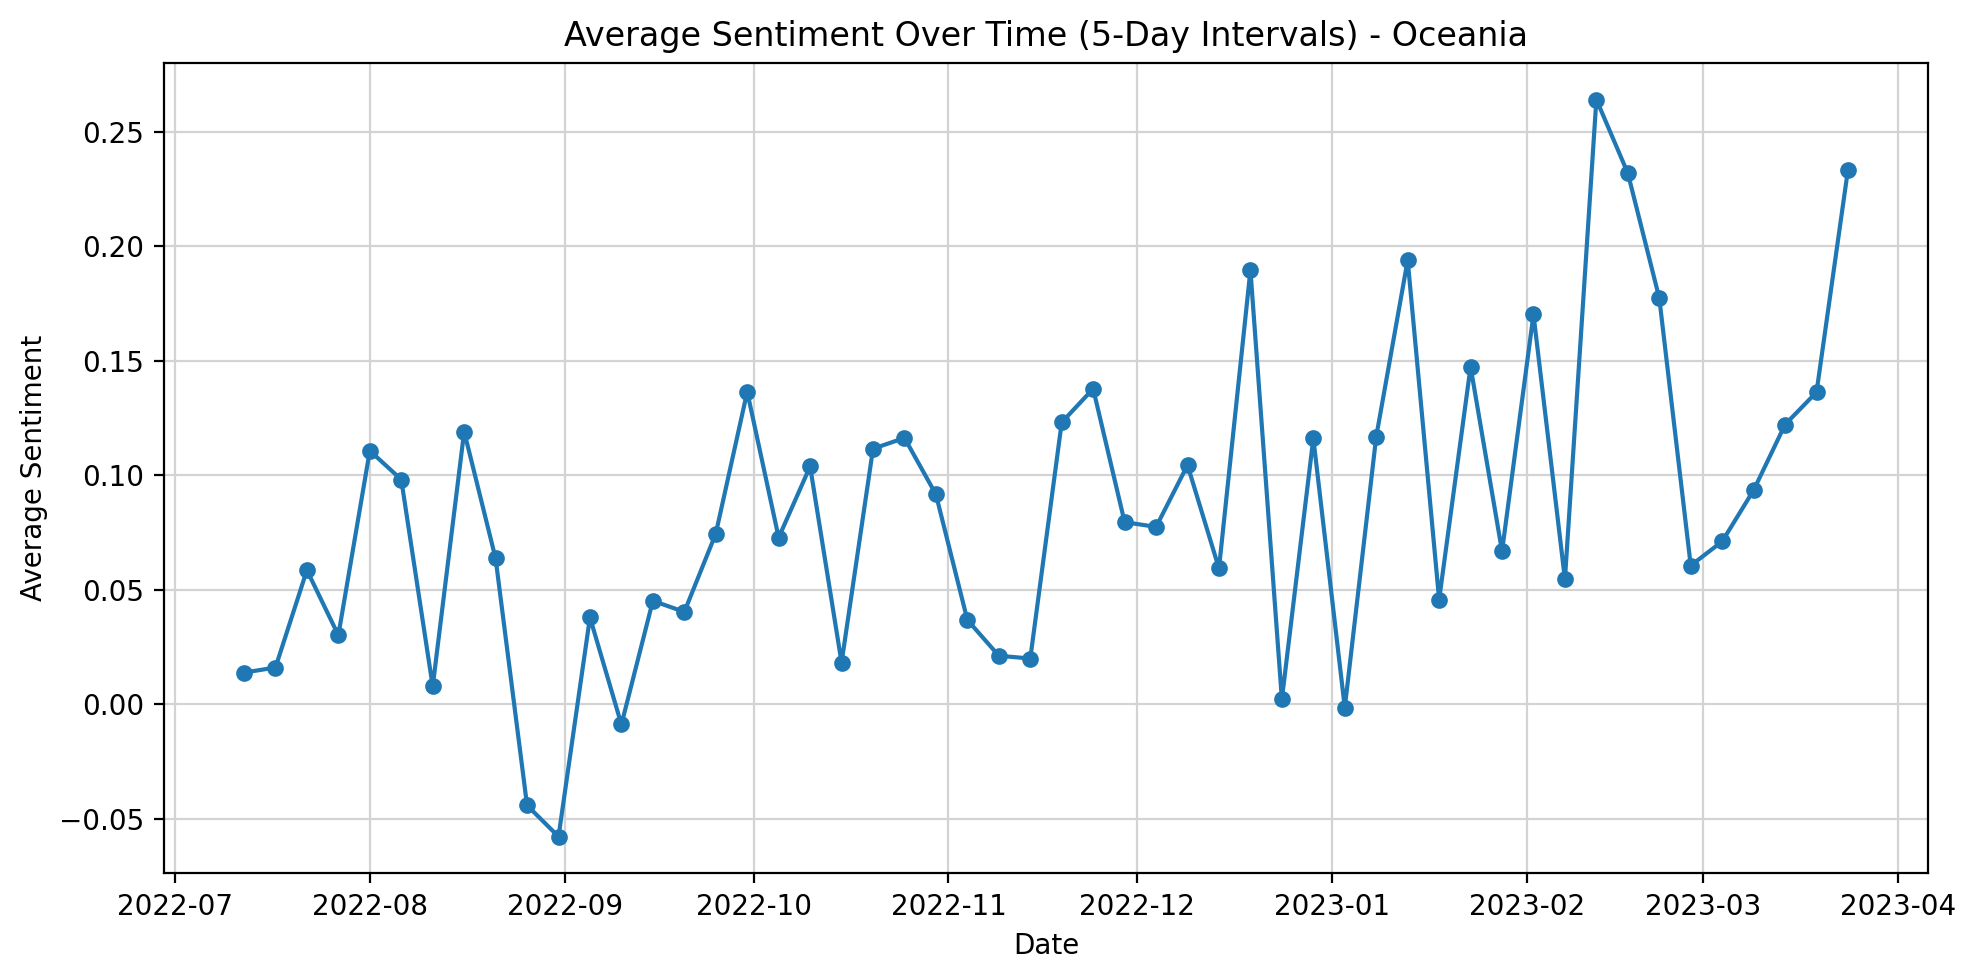

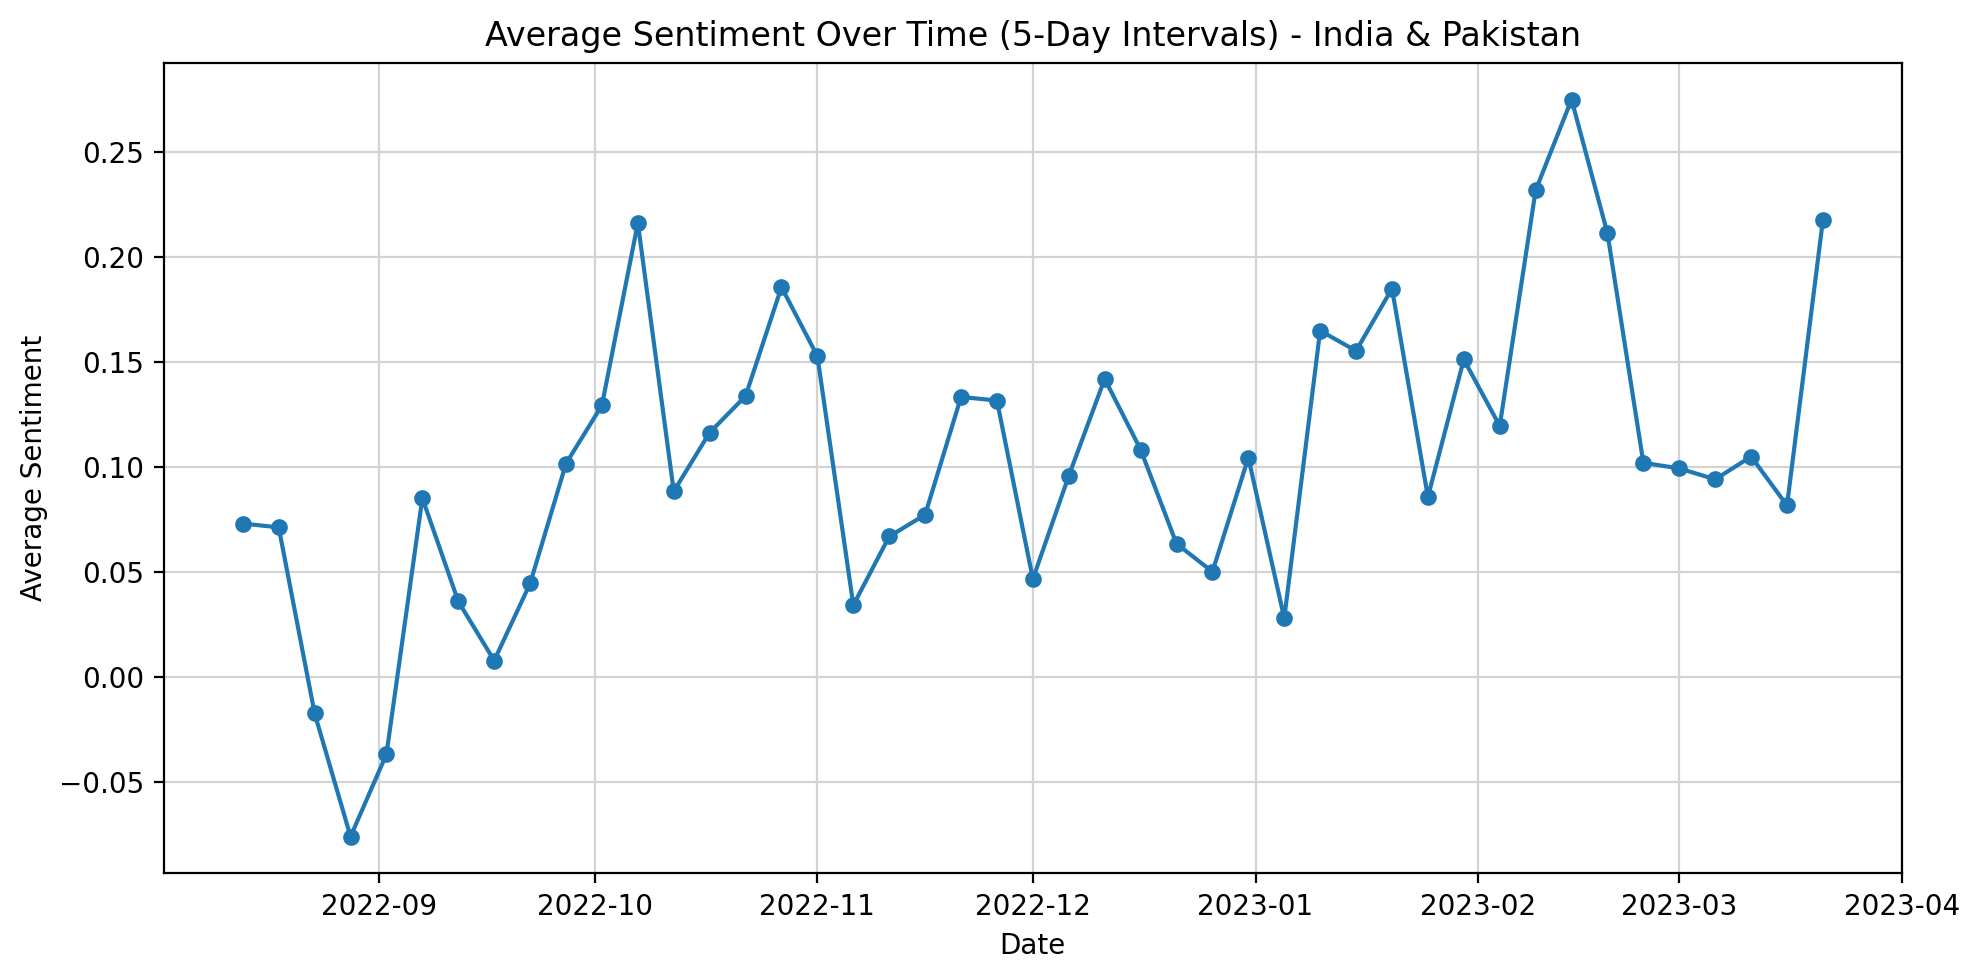

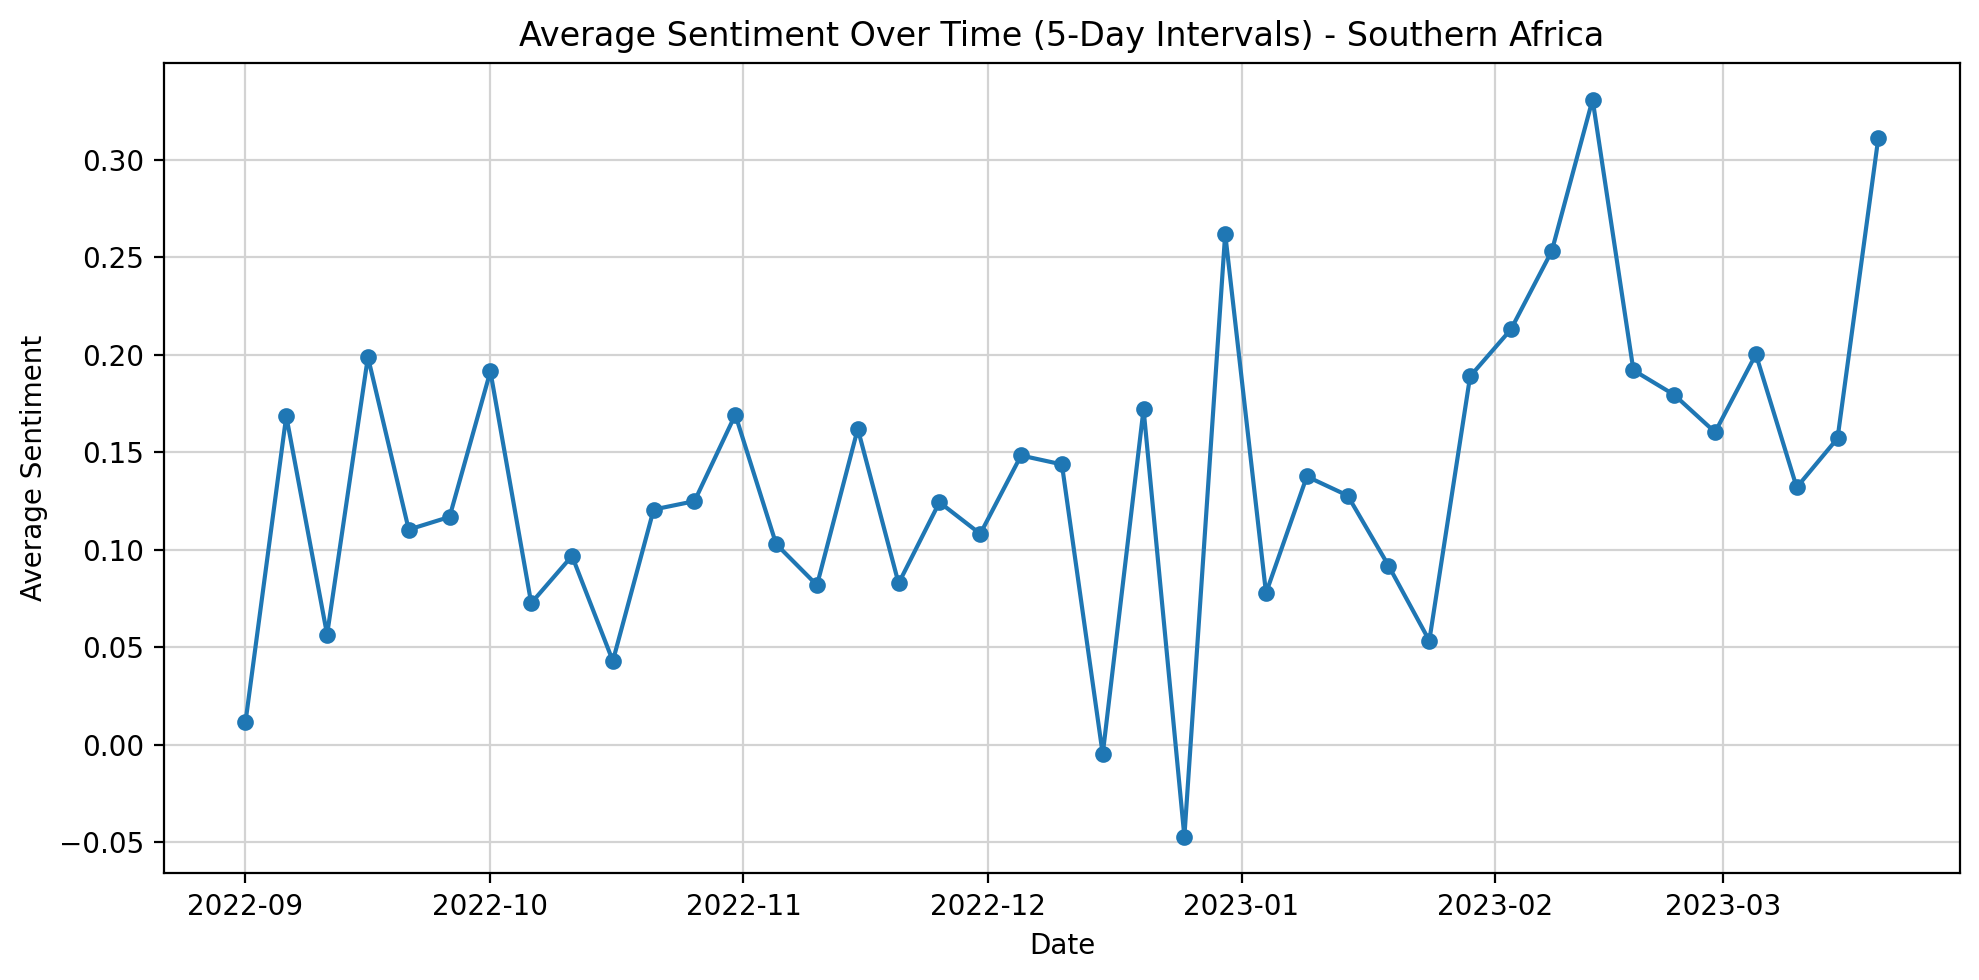

In [34]:
regions = df['region'].unique()

time_frame = '5D'

for region in regions:
    df_region = df[df['region'] == region]
    df_resampled = df_region.resample(time_frame, on='date')['sentiment'].mean().reset_index()

    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(df_resampled['date'], df_resampled['sentiment'], marker='o', linestyle='-', markersize=5)
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment')
    plt.title(f'Average Sentiment Over Time (5-Day Intervals) - {region}')
    plt.grid(axis='both', color='lightgrey')
    plt.tight_layout()
    plt.show()

In [35]:
# Resample data for each region
dfs_resampled = []
for region in df['region'].unique():
    df_region = df[df['region'] == region]
    df_resampled = df_region.resample('5D', on='date')['sentiment'].mean().reset_index()
    df_resampled['region'] = region
    dfs_resampled.append(df_resampled)

df_all_regions = pd.concat(dfs_resampled)

fig = px.line(df_all_regions, x='date', y='sentiment', color='region', markers=True, title='Average Sentiment Over Time (5-Day Intervals) - All Regions')
fig.update_traces(mode='lines+markers')

# Update the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Average Sentiment',
    legend_title='Region',
    plot_bgcolor='rgba(255, 255, 255, 1)',
    xaxis=dict(gridcolor='rgba(230, 230, 230, 1)'),
    yaxis=dict(gridcolor='rgba(230, 230, 230, 1)'),
    width=1500,
    height=600
)

fig.show()

It is clear the is no real trend in sentiment that can be seen in any of these charts over large regions, so we will try to see if there is smoother and more consistent trends in specific countries.

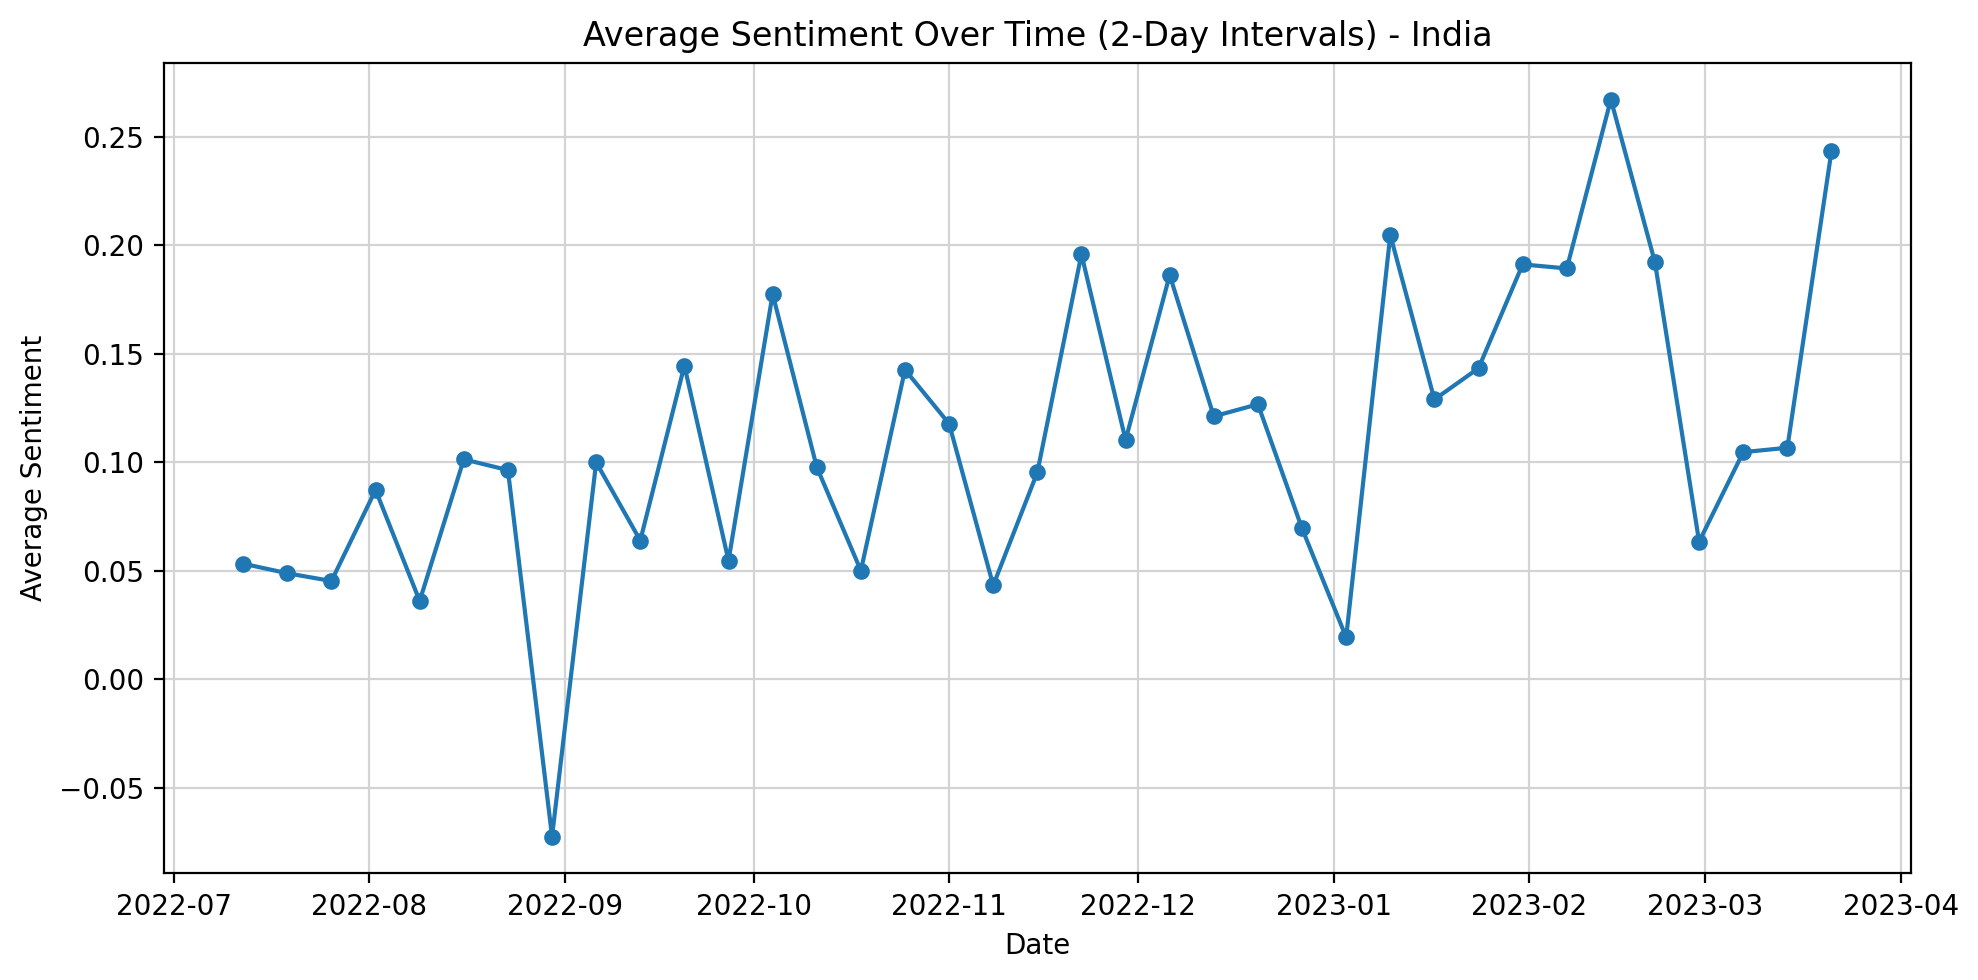

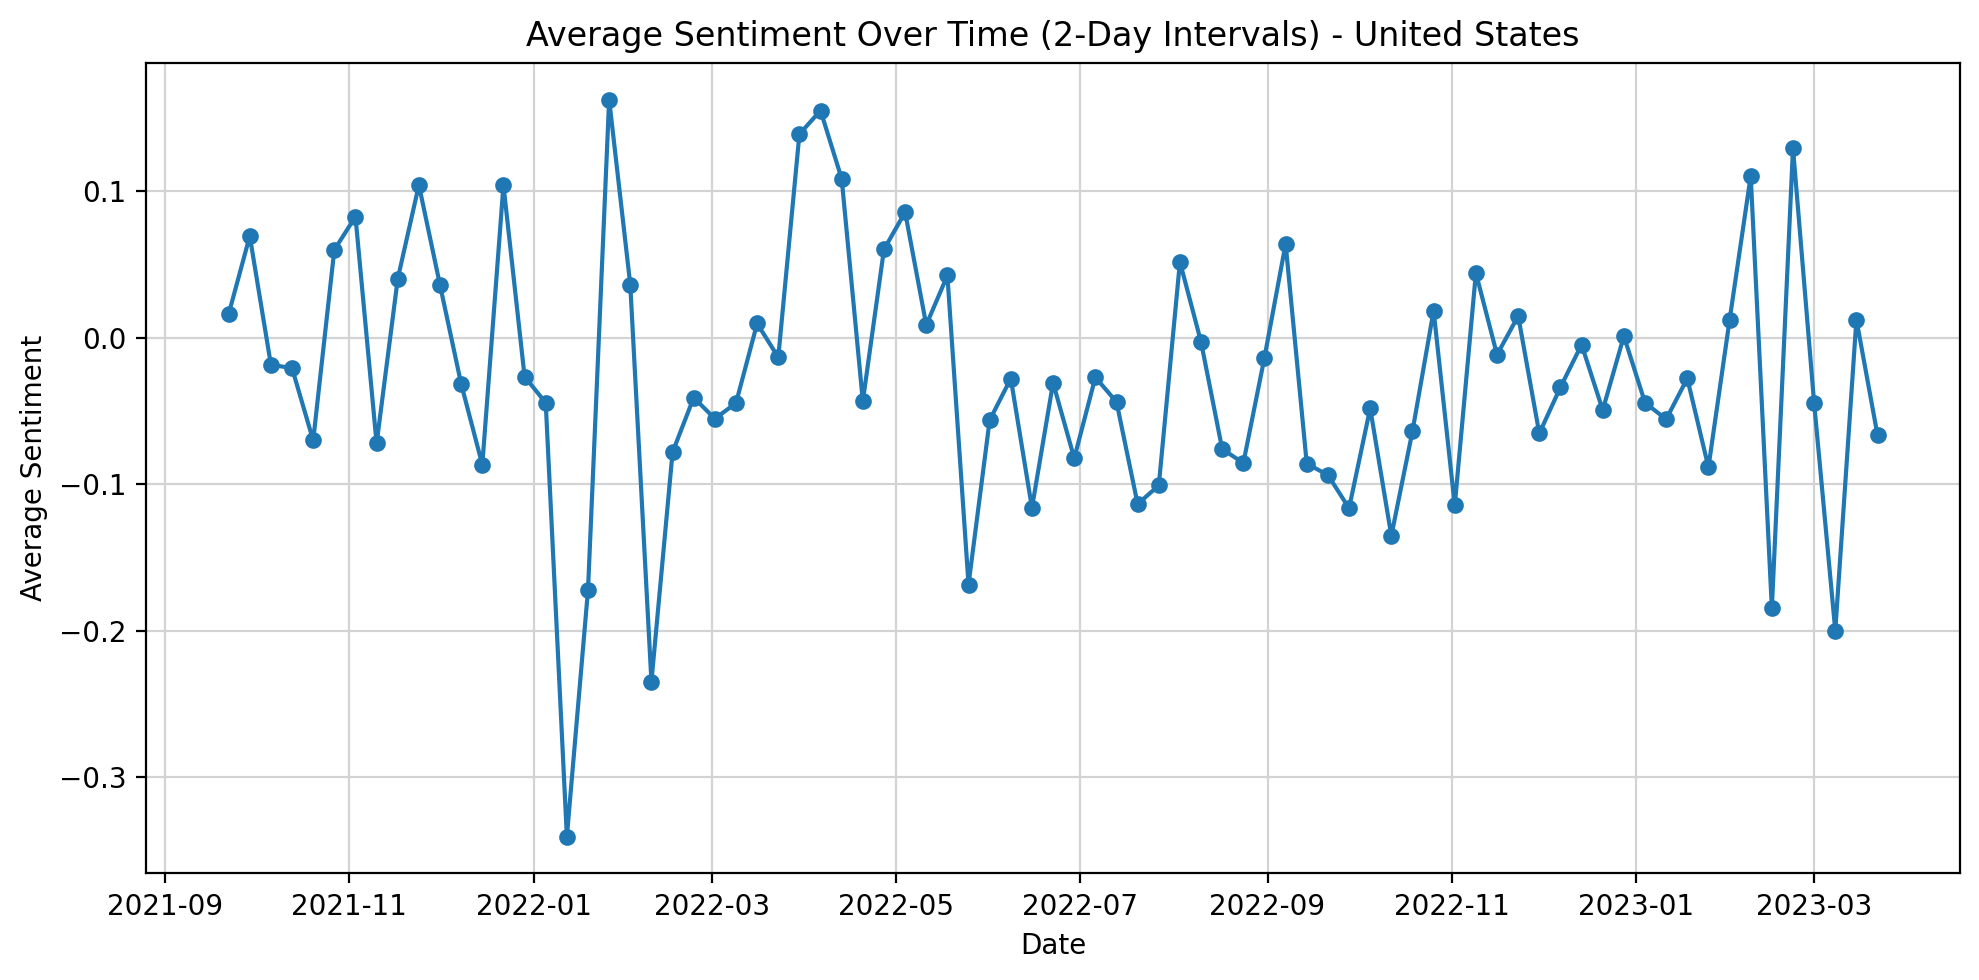

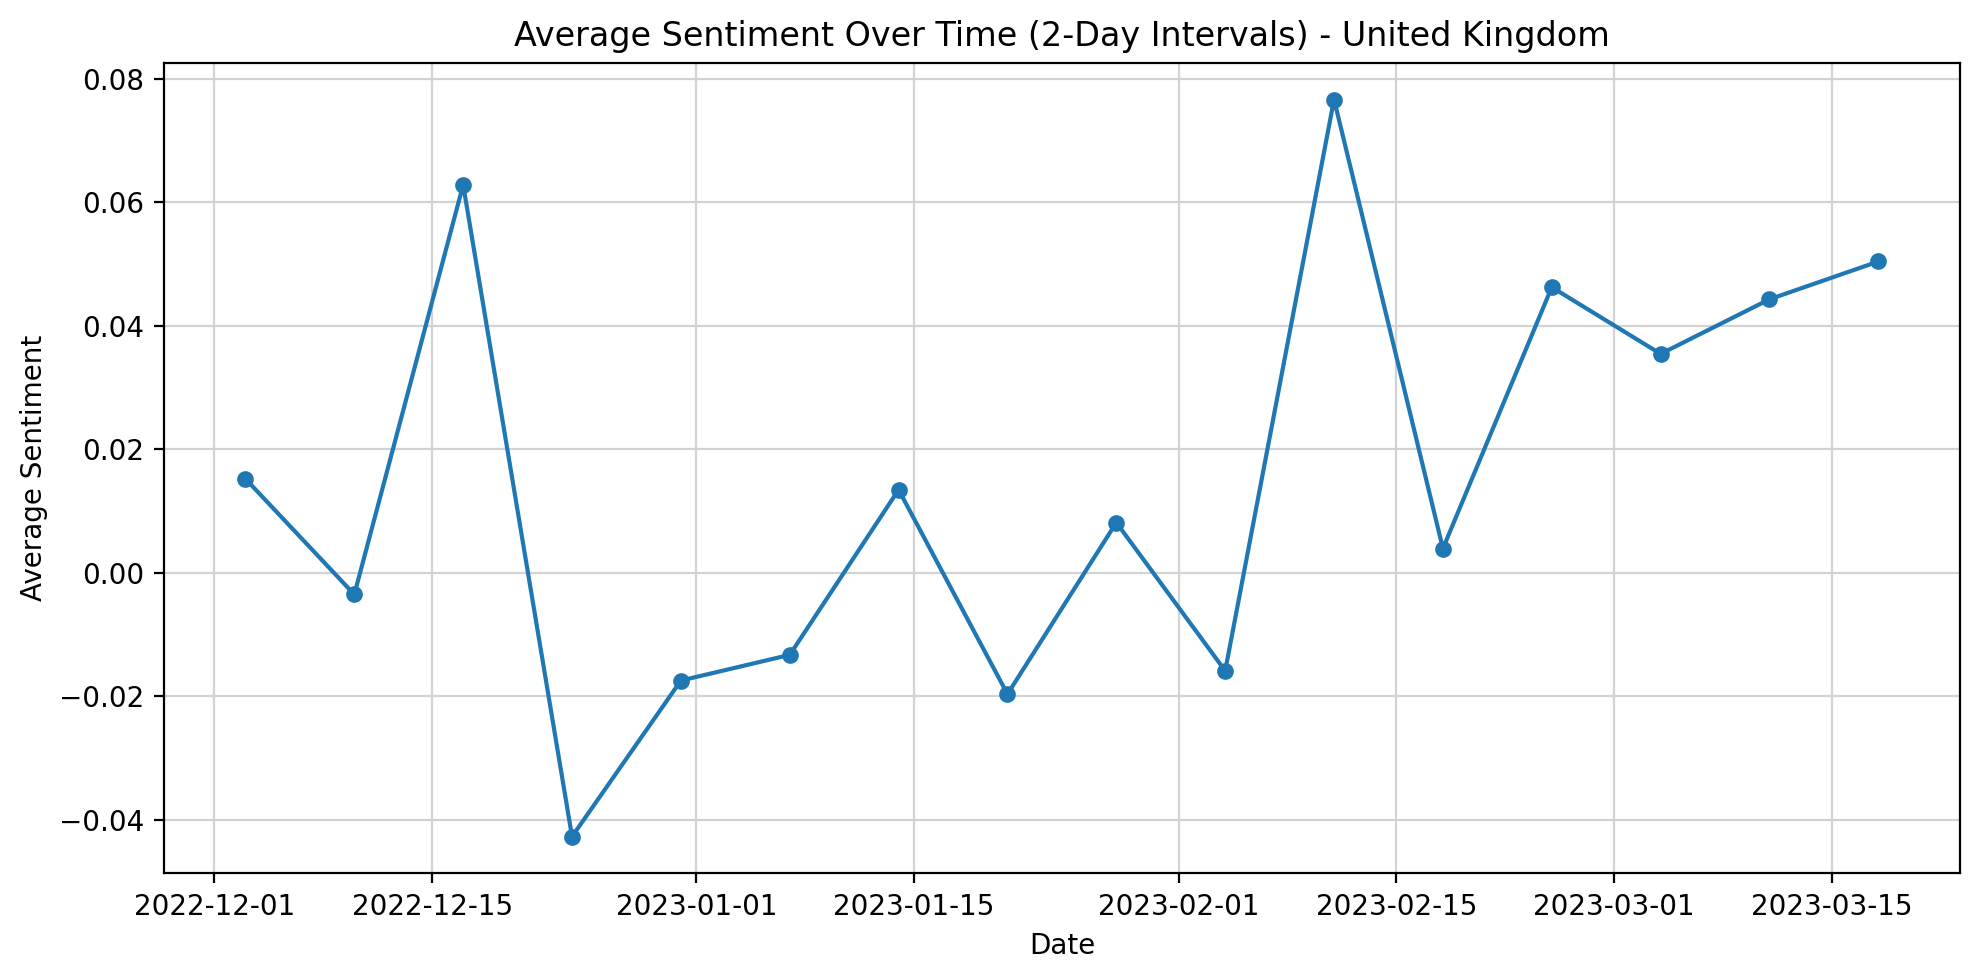

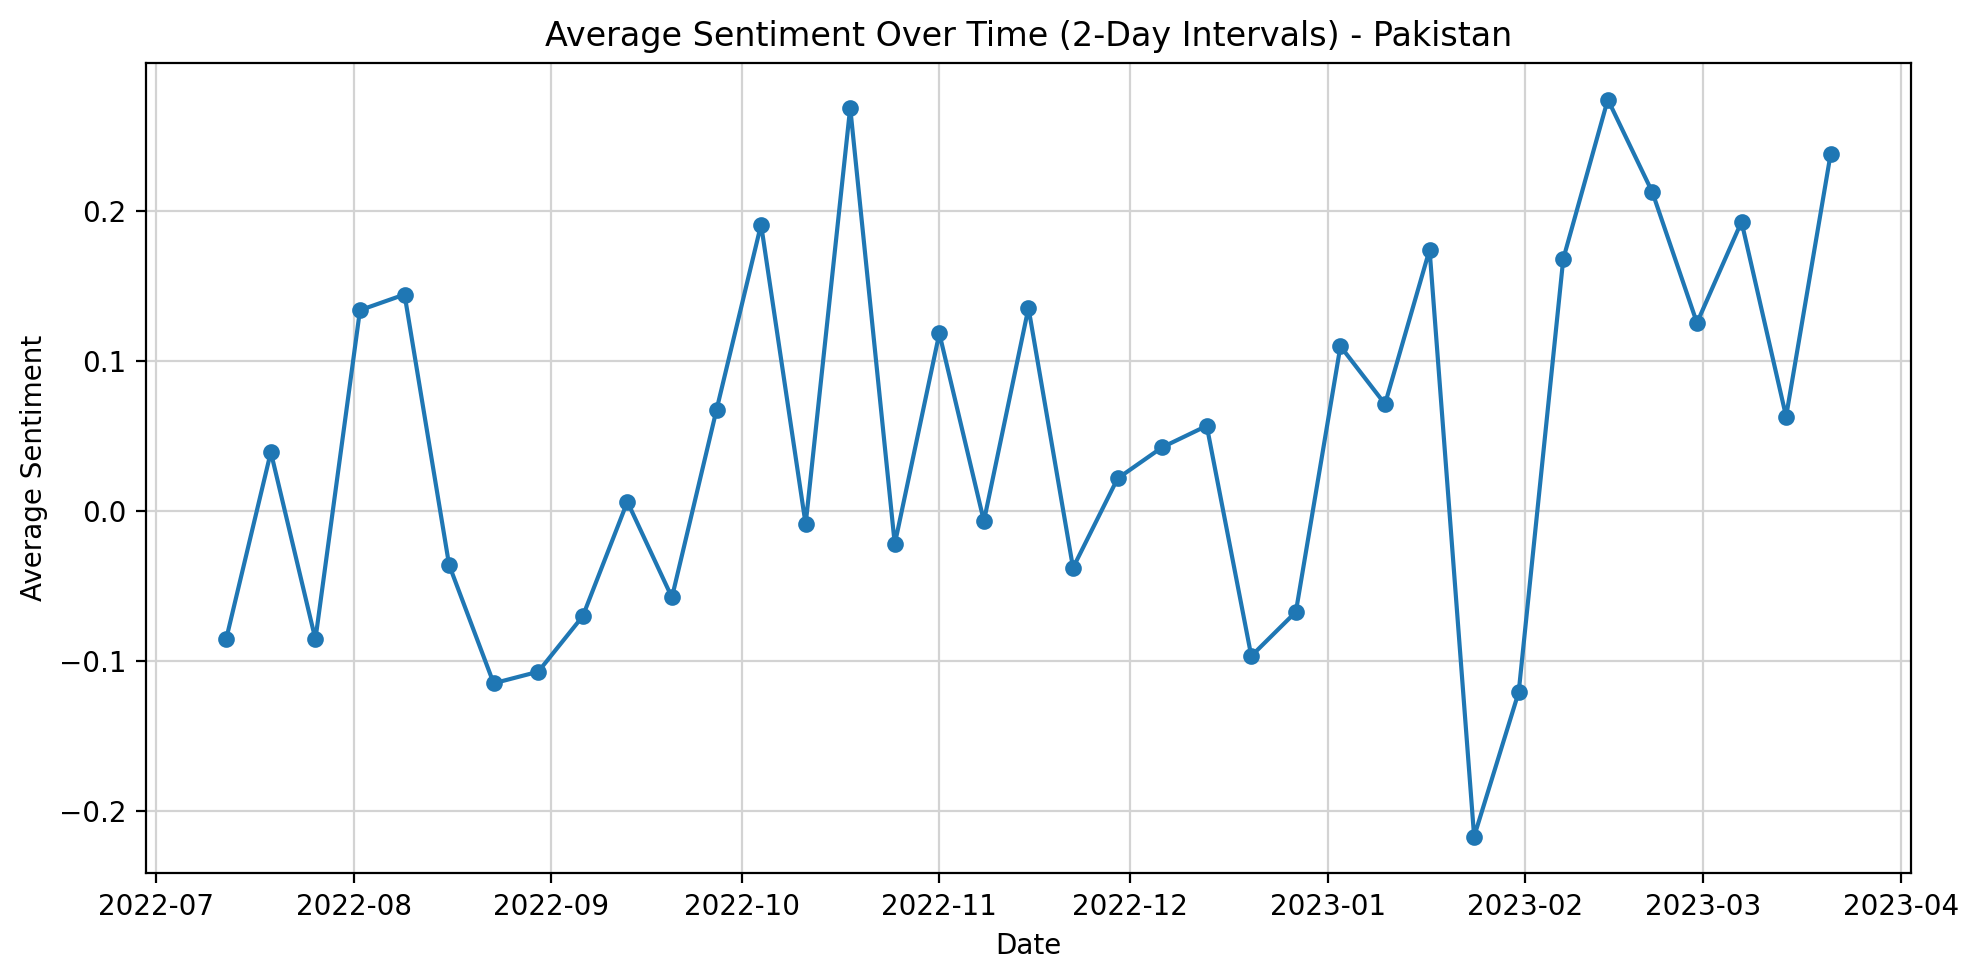

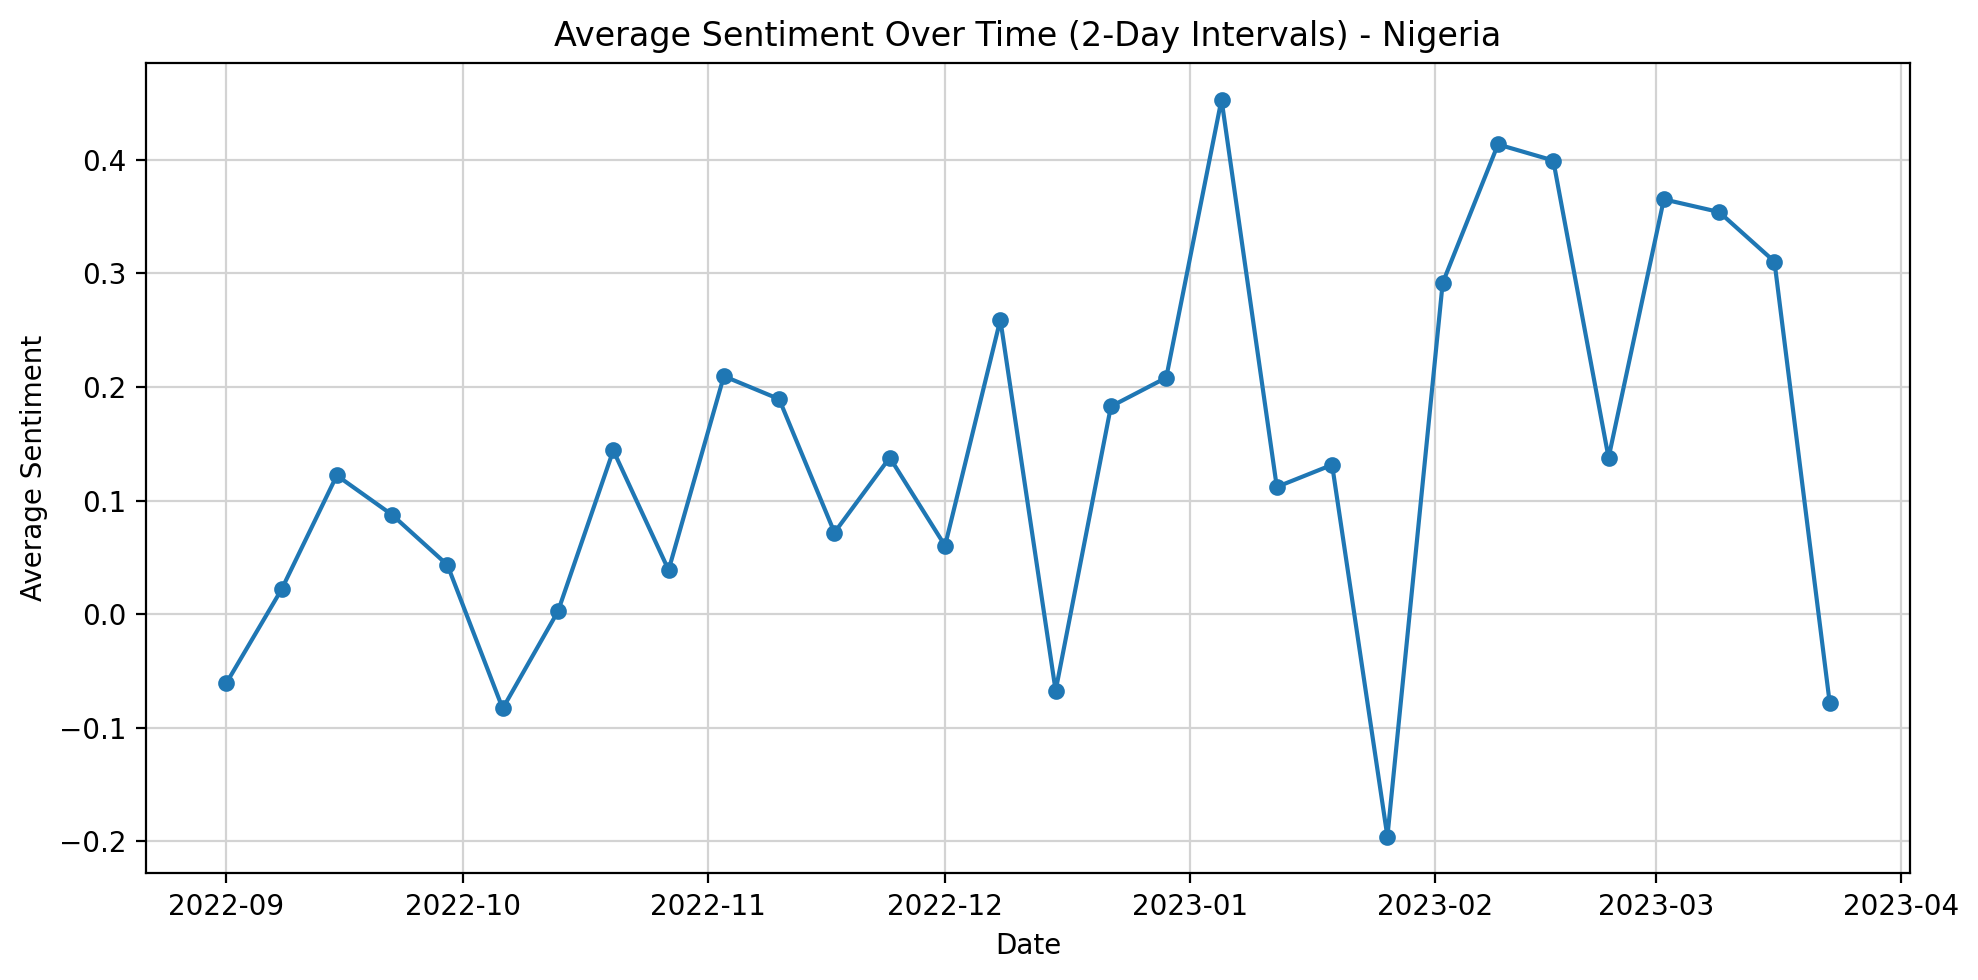

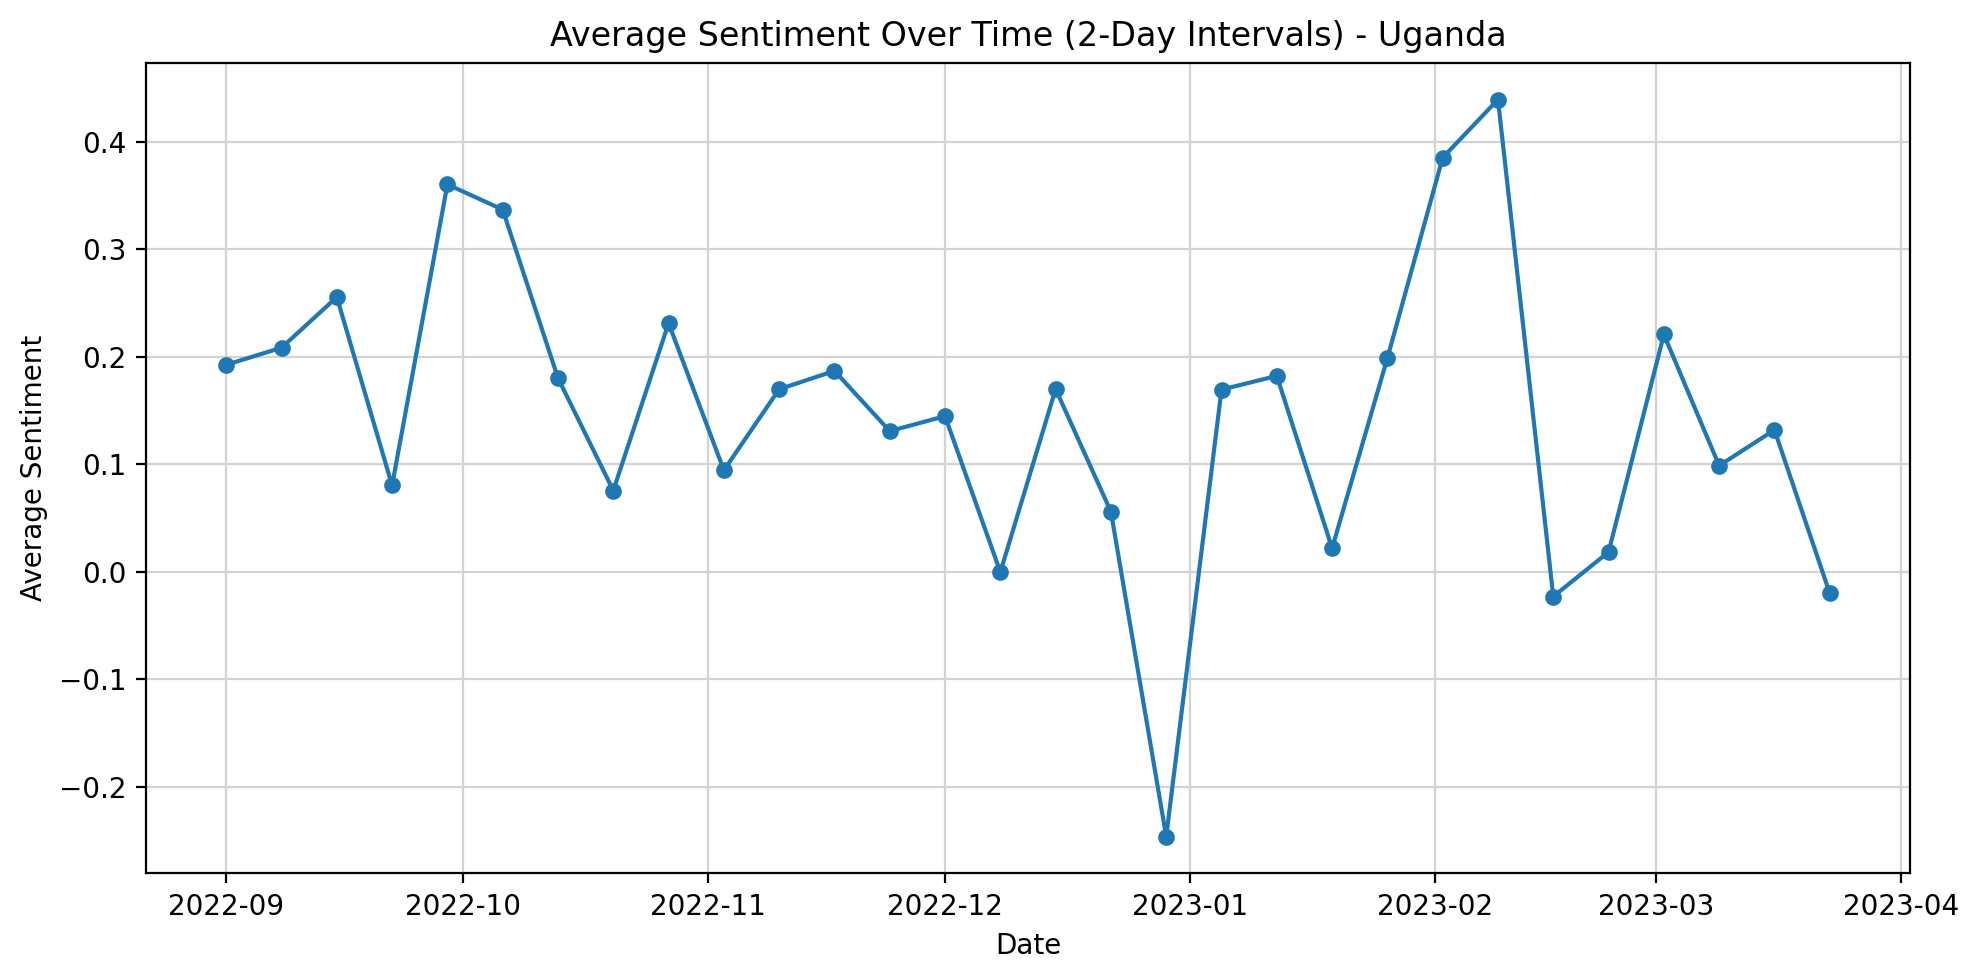

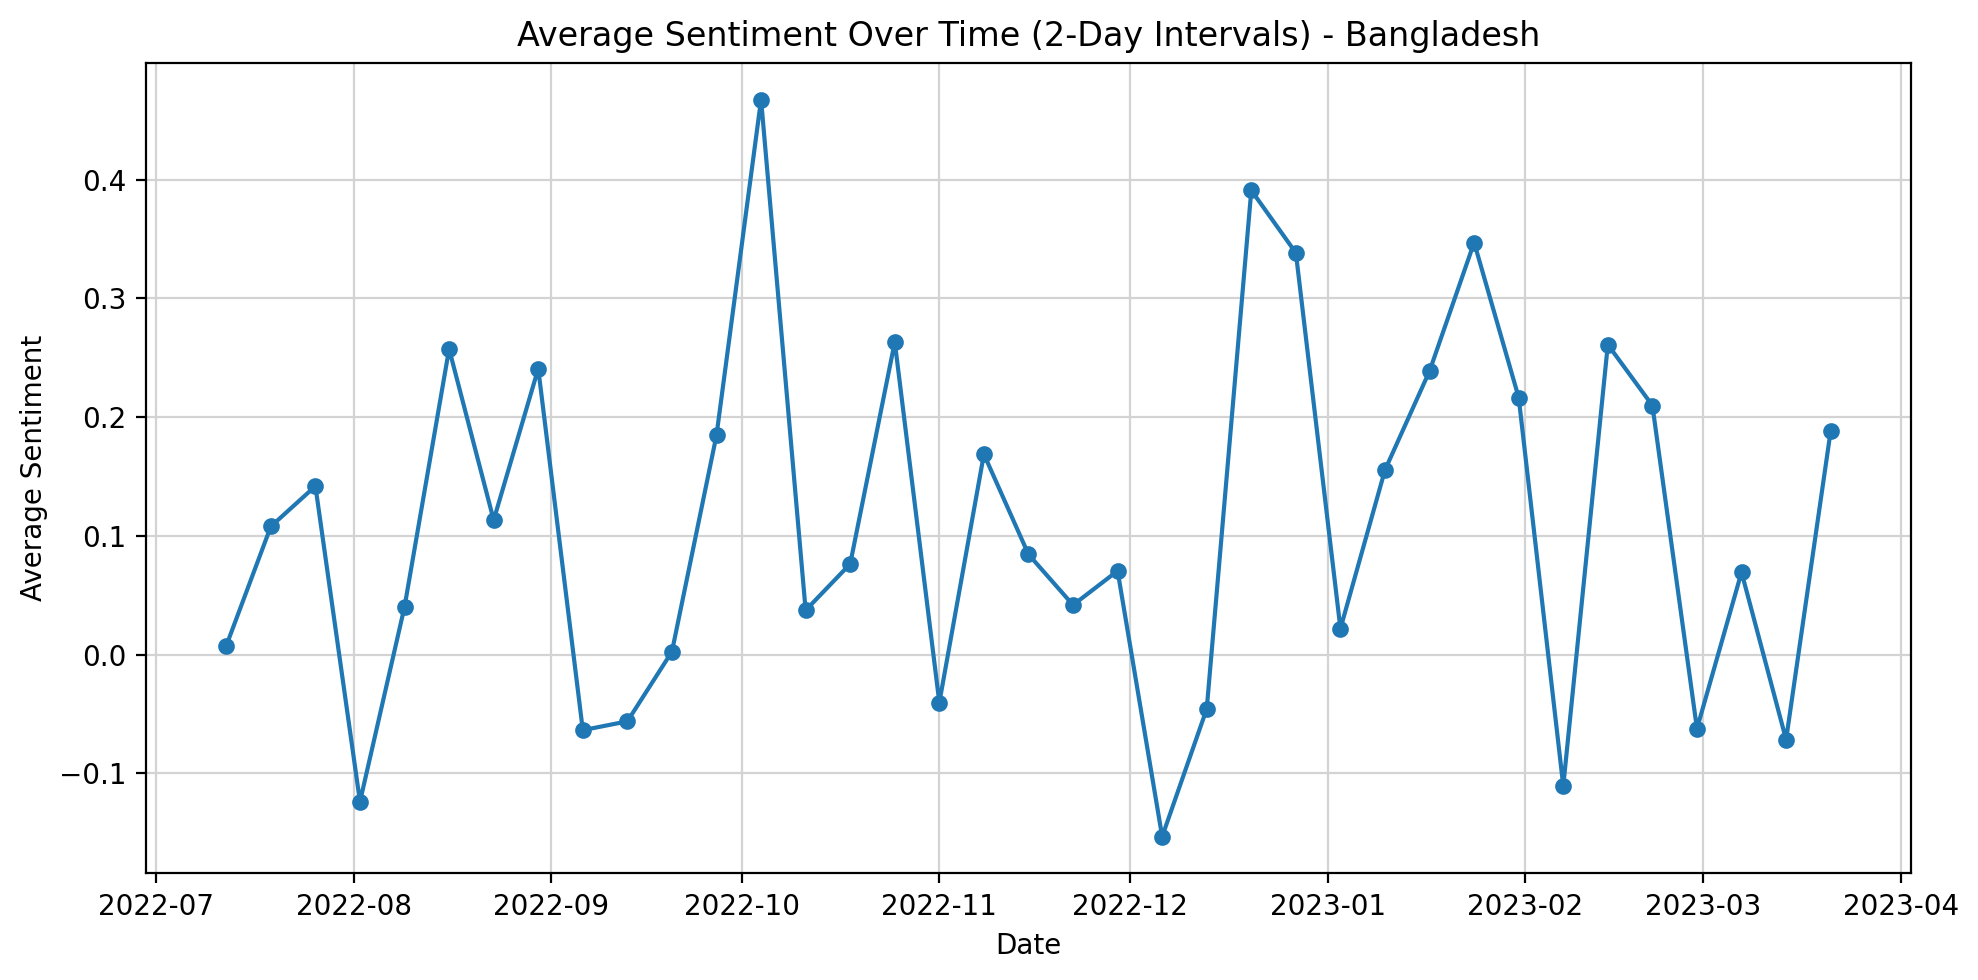

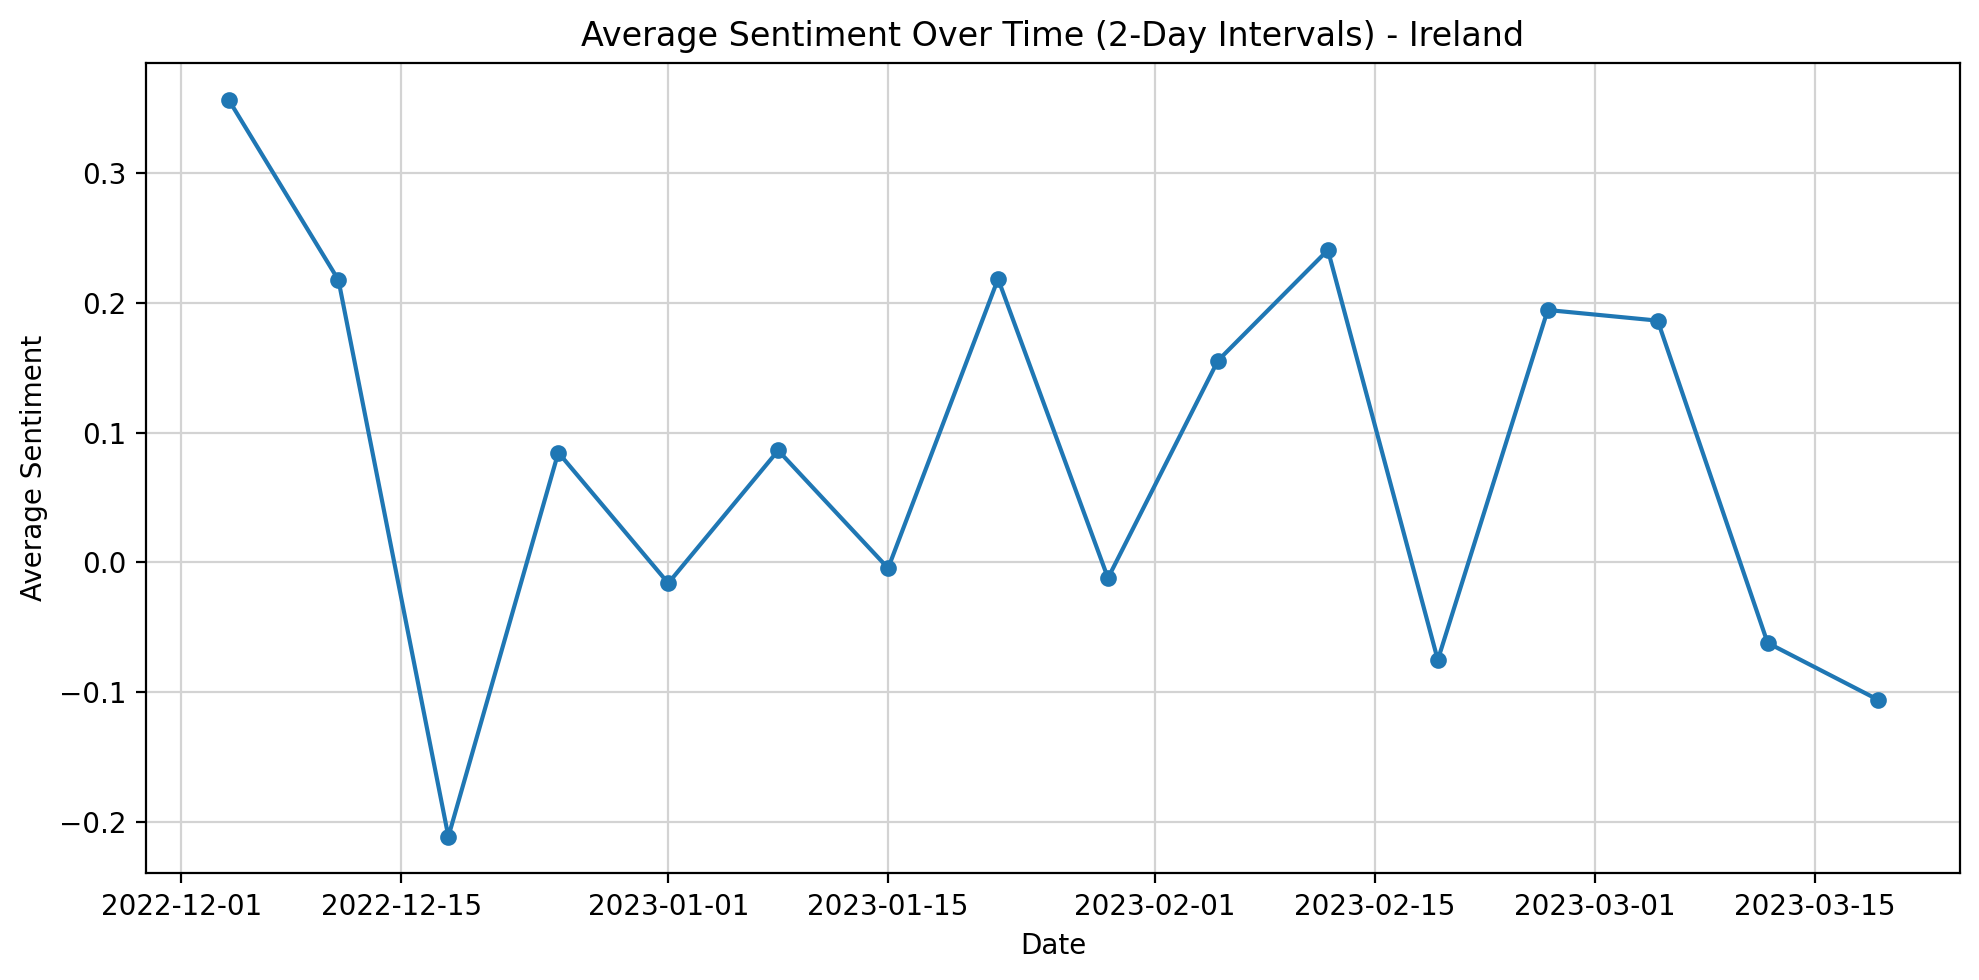

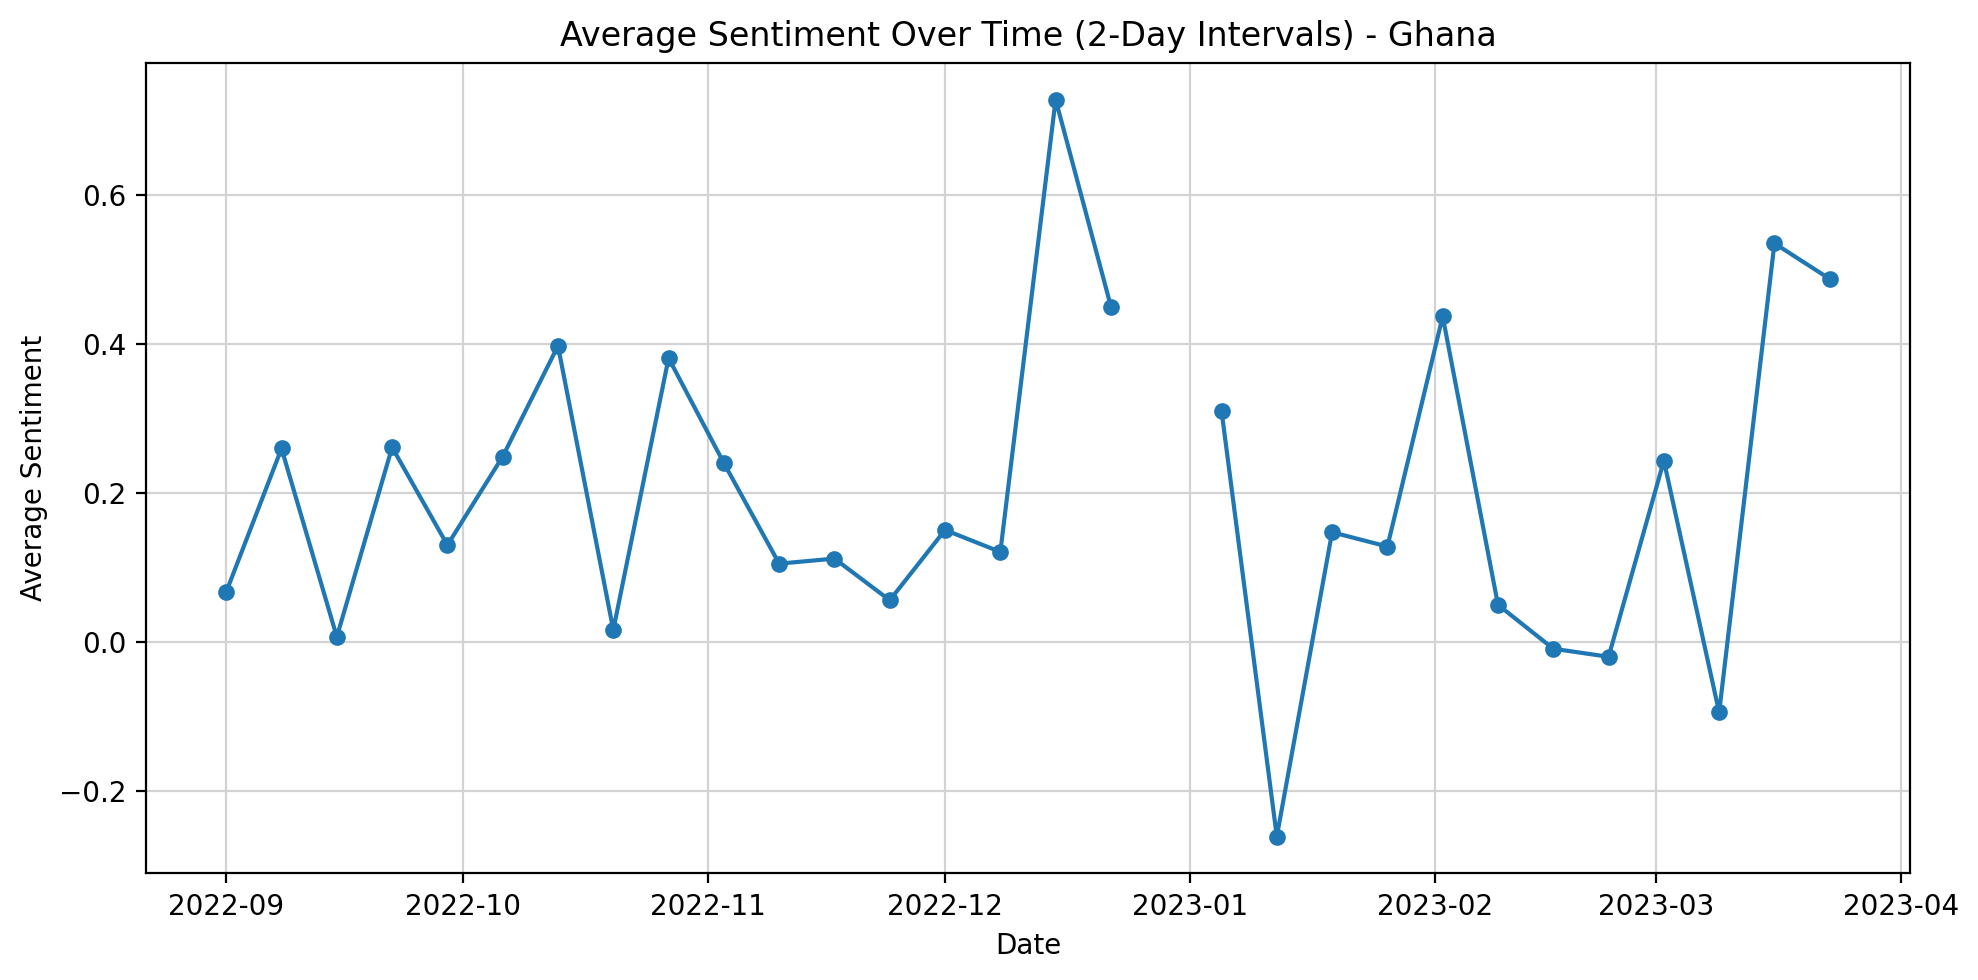

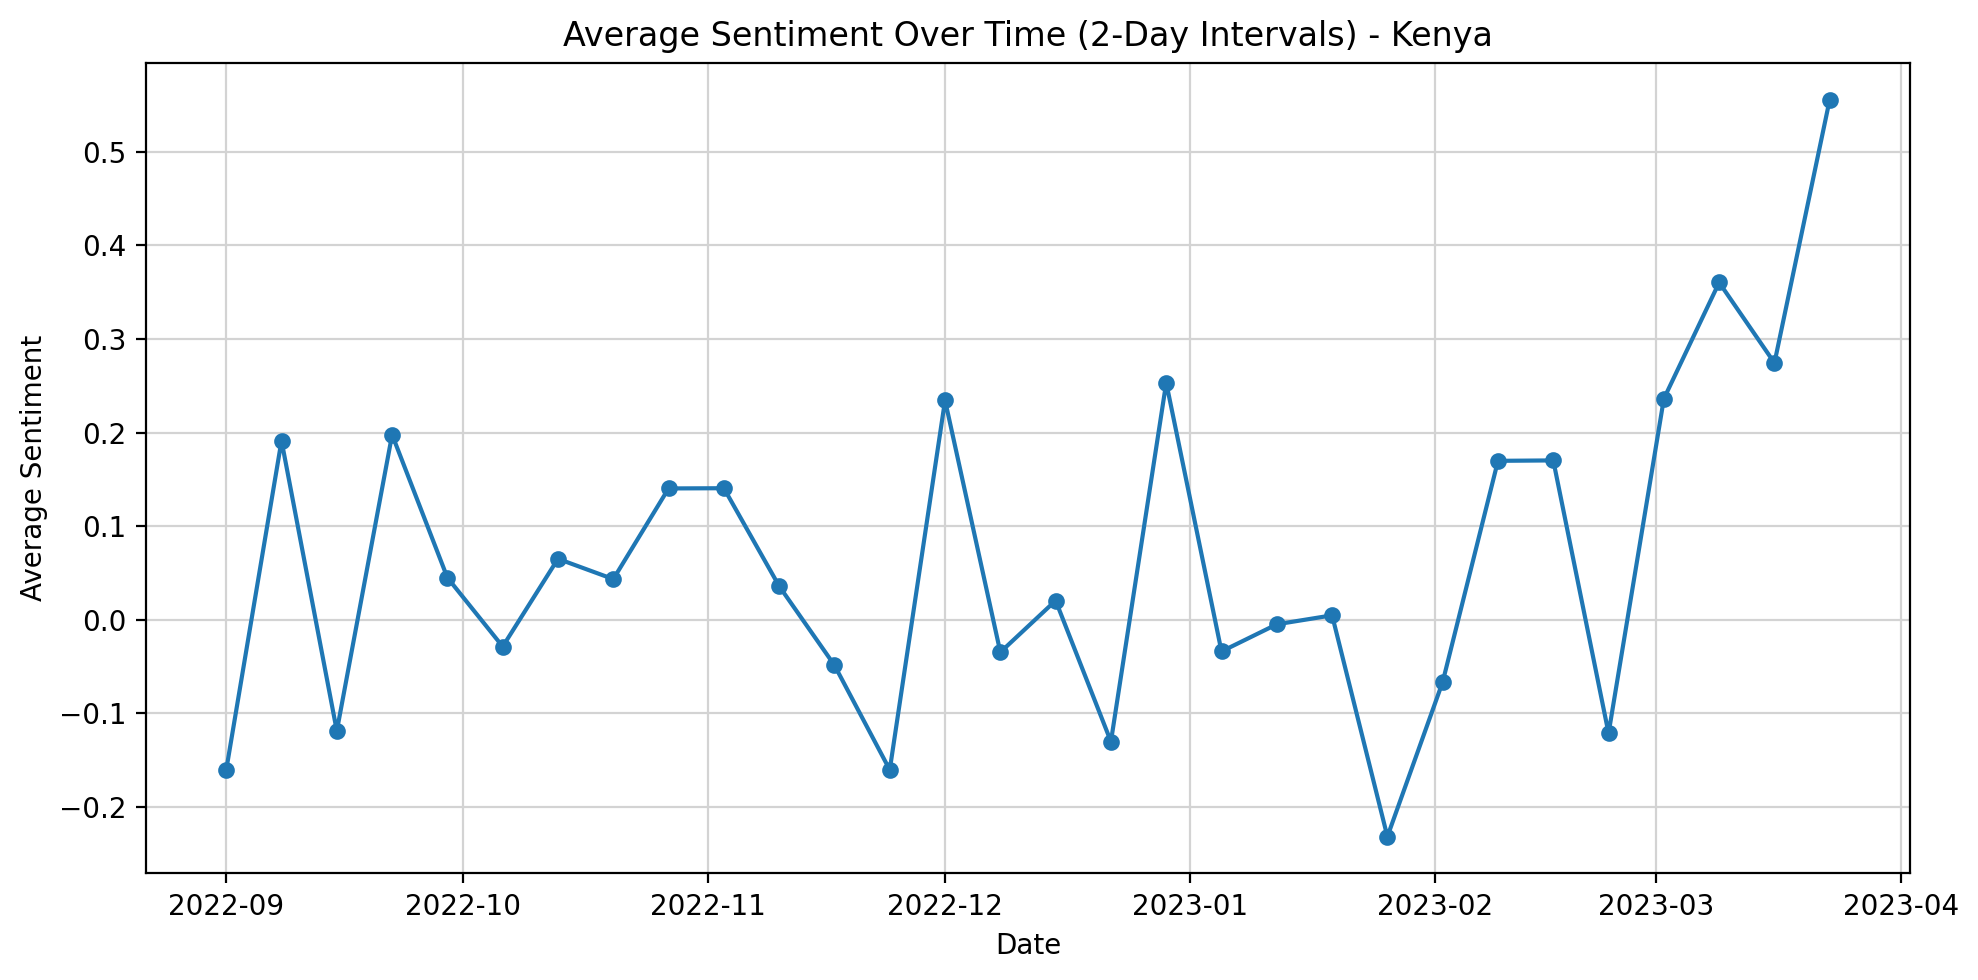

In [36]:
top_countries = df['country_name'].value_counts().nlargest(10).index

time_frame = '7D'

for country in top_countries:
    df_country = df[df['country_name'] == country]
    df_resampled = df_country.resample(time_frame, on='date')['sentiment'].mean().reset_index()

    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(df_resampled['date'], df_resampled['sentiment'], marker='o', linestyle='-', markersize=5)
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment')
    plt.title(f'Average Sentiment Over Time (2-Day Intervals) - {country}')
    plt.grid(axis='both', color='lightgrey')
    plt.tight_layout()
    plt.show()

It appears as most of the countries from top 10 tweet counts keep a consistently within their sentiment change although it does fluctuate alot in the range, appart from the UK which appears to fluctuate a lot more than the others ranging betweet as low as -0.4 and as high as 0.8

#### 2. Vectorizing Tokens

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [38]:
# Vectorize the tokens
vectorizer = CountVectorizer()
X_lda = vectorizer.fit_transform(df['tokens'].apply(lambda tokens: ' '.join(tokens)))

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_lda)

for i, topic in enumerate(lda.components_):
    print(f'Topic {i}:')
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print()

Topic 0:
['need', 'opinion', 'comment', 'good', 'know', 'alexandria', 'time', 'people', 'change', 'climate']

Topic 1:
['life', 'amp', 'plant', 'air', 'carbon', 'energy', 'people', 'tree', 'change', 'climate']

Topic 2:
['better', 'save', 'would', 'earth', 'new', 'day', 'amp', 'year', 'change', 'climate']

Topic 3:
['india', 'war', 'like', 'la', 'time', 'de', 'world', 'climate', 'change', 'amp']

Topic 4:
['extreme', 'drought', 'soil', 'year', 'warming', 'weather', 'amp', 'global', 'change', 'climate']

Topic 5:
['impact', 'like', 'effect', 'due', 'time', 'see', 'dont', 'people', 'climate', 'change']

Topic 6:
['conference', 'community', 'issue', 'action', 'environment', 'youth', 'impact', 'amp', 'change', 'climate']

Topic 7:
['know', 'people', 'world', 'need', 'real', 'like', 'one', 'global', 'change', 'climate']

Topic 8:
['time', 'get', 'let', 'know', 'world', 'dont', 'need', 'people', 'change', 'climate']

Topic 9:
['day', 'year', 'problem', 'security', 'water', 'world', 'food', '

plotting each topis word frequencys

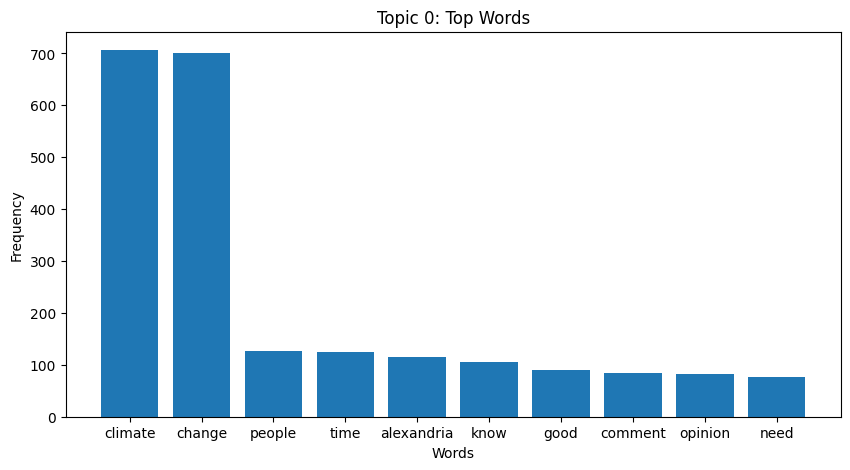

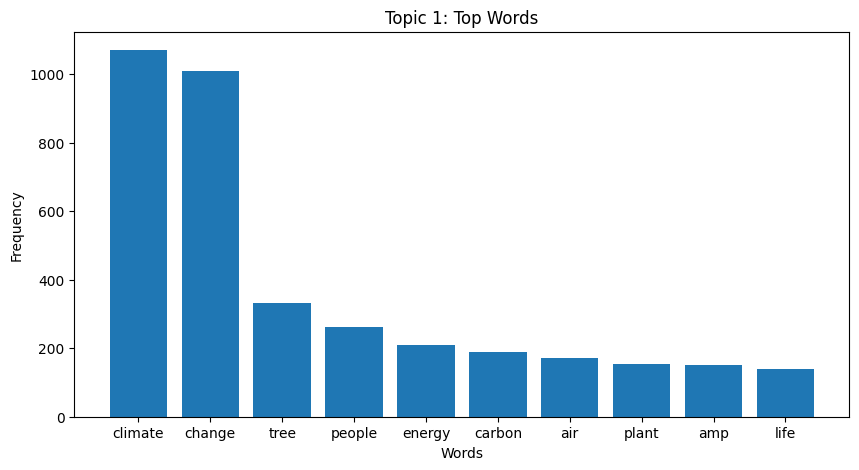

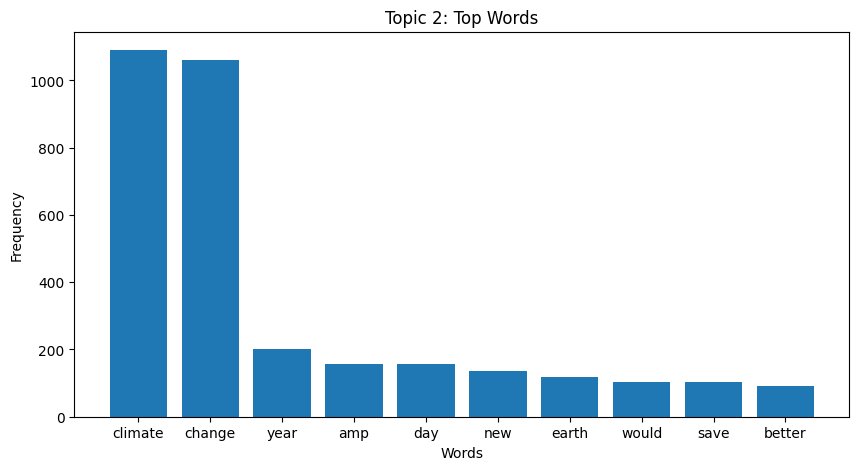

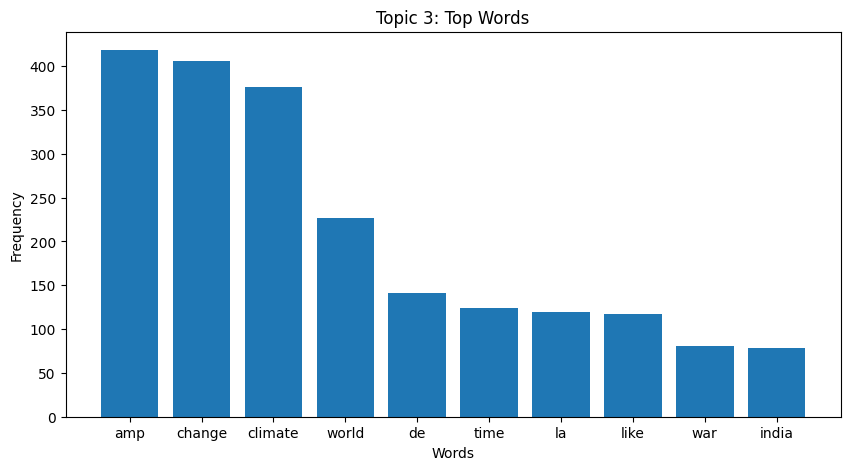

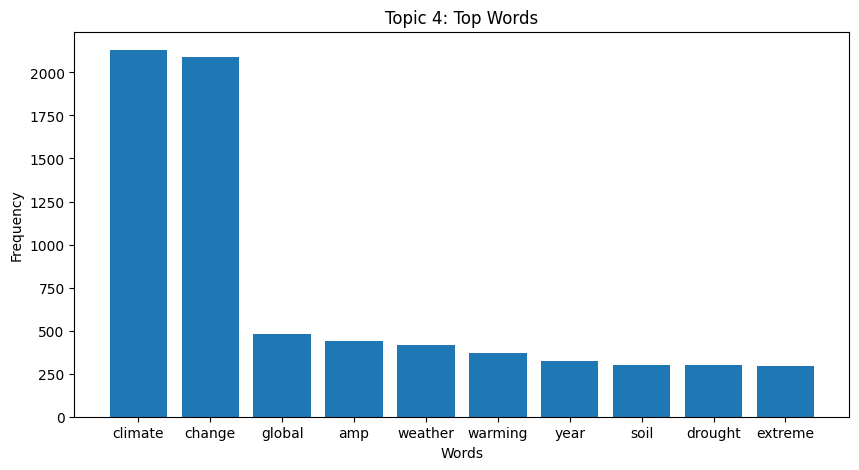

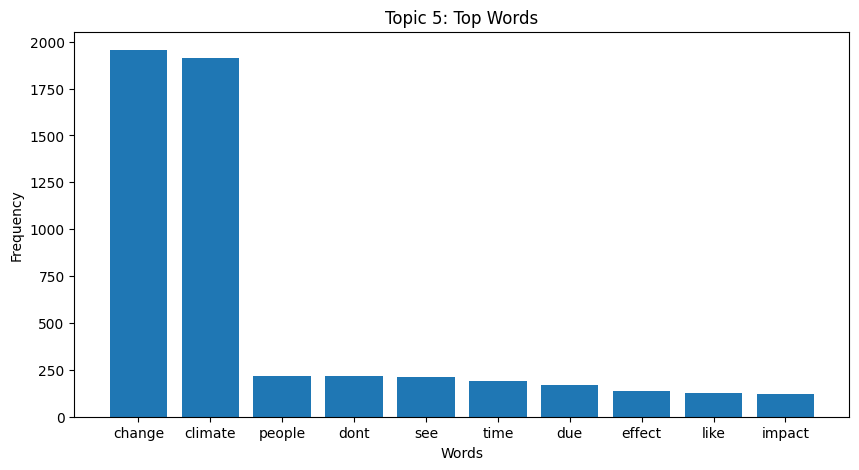

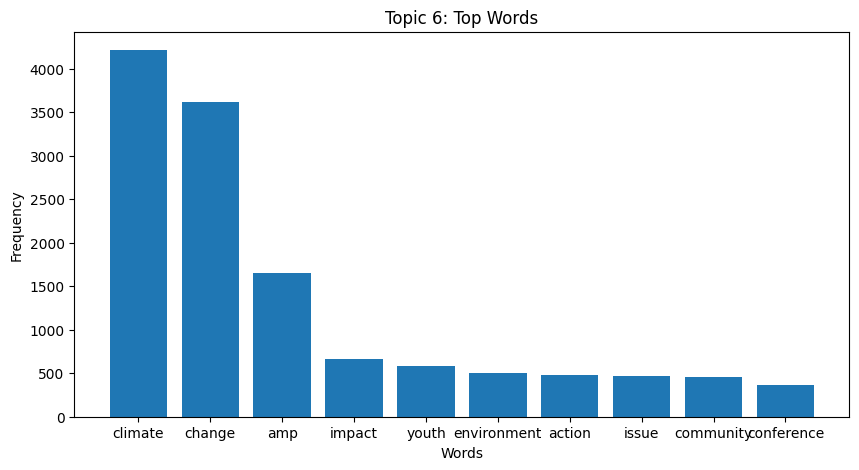

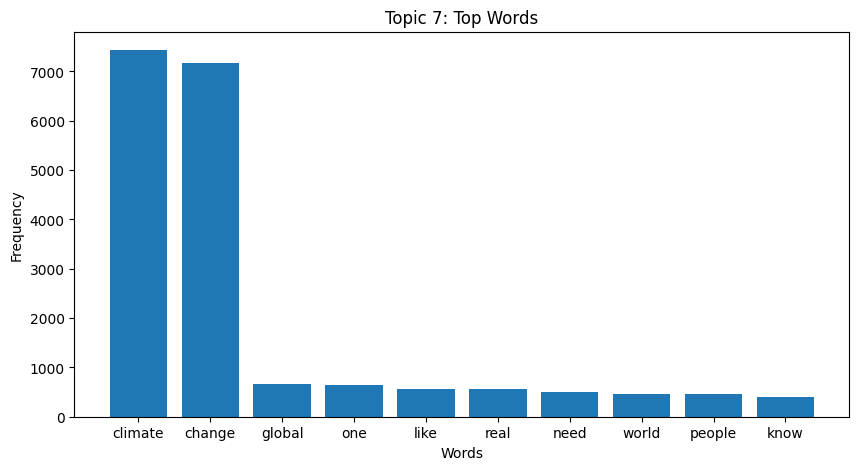

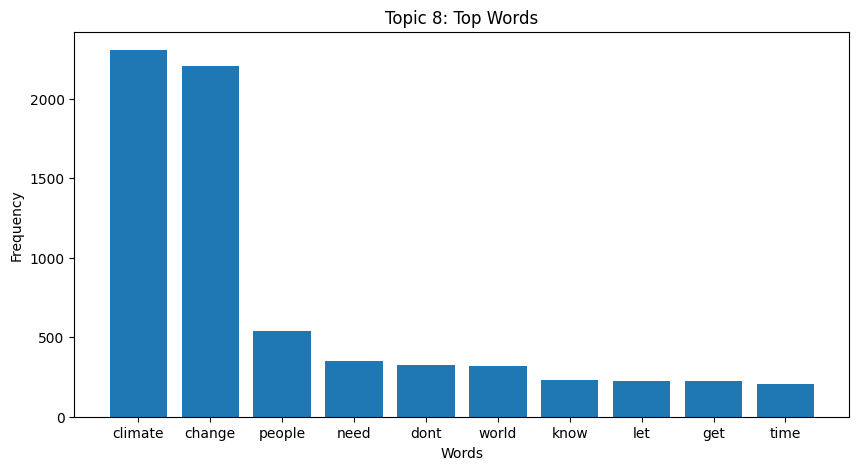

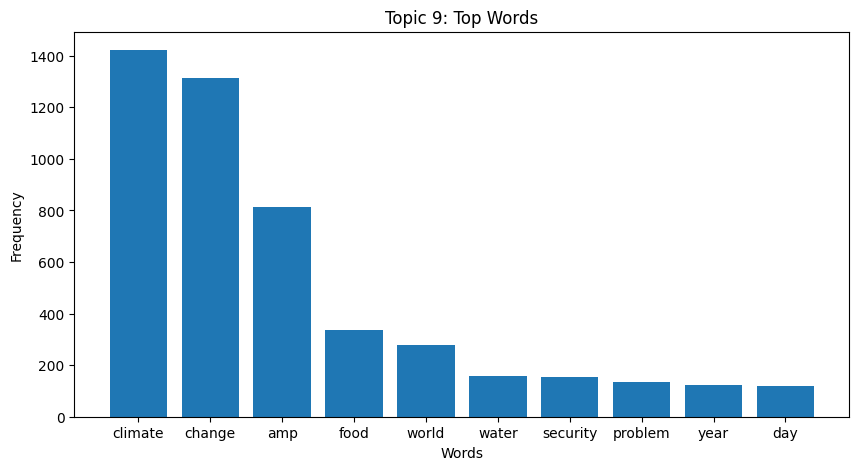

In [39]:
def plot_top_words(topic_word_distribution, topic_id):
    words = [item[0] for item in topic_word_distribution]
    frequencies = [item[1] for item in topic_word_distribution]
    
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Topic {topic_id}: Top Words')
    plt.show()

for i, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[-10:][::-1]
    top_words = [(vectorizer.get_feature_names_out()[index], topic[index]) for index in top_word_indices]
    plot_top_words(top_words, i)

#### 3. Text Classification

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# creating labels based on sentiment scores
def sentiment_to_label(sentiment_score):
    if sentiment_score > 0.05:
        return 'positive'
    elif sentiment_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['label'] = df['sentiment'].apply(sentiment_to_label)

# splitting training and testing sets
X_text = df['cleaned_content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)


# using TfidVectoriser to convert text data to matrix of TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# training classifier with multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# evaluating classifer on test set

y_pred = clf.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

      


Accuracy: 0.6593318663732747
              precision    recall  f1-score   support

    negative       0.74      0.68      0.71      1641
     neutral       0.88      0.14      0.25      1130
    positive       0.61      0.91      0.73      2228

    accuracy                           0.66      4999
   macro avg       0.74      0.58      0.56      4999
weighted avg       0.71      0.66      0.61      4999



#### fine-tuning the model's hyperparameters

* Grid search

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]}

# Create the GridSearchCV object
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=5)

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'alpha': 0.1}
Best accuracy: 0.7000250062515629


* Randomized Search

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for alpha
param_dist = {'alpha': np.logspace(-3, 2, 50)}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(MultinomialNB(), param_dist, scoring='accuracy', cv=5, n_iter=20)

# Fit the model
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters and accuracy
print("Best parameters:", random_search.best_params_)
print("Best accuracy:", random_search.best_score_)

Best parameters: {'alpha': 0.054286754393238594}
Best accuracy: 0.7011252813203301


* Bayesian Optimization

In [43]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(params):
    clf = MultinomialNB(alpha=params['alpha'])
    score = np.mean(cross_val_score(clf, X_train_tfidf, y_train, cv=5, scoring='accuracy'))
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space for alpha
space = {
    'alpha': hp.loguniform('alpha', -3, 2)
}

# Run the optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

# Print the best parameters and accuracy
print("Best parameters:", best)
print("Best accuracy:", -trials.best_trial['result']['loss'])

100%|██████████| 50/50 [00:07<00:00,  6.65trial/s, best loss: -0.7019754938734684]
Best parameters: {'alpha': 0.05975190240480311}
Best accuracy: 0.7019754938734684


Out of the 3 approaches to find optimal parameters although all 3 were very close, the Bayesian Optimization method found the best accuracy of 0.7019 with alpha value of 0.059 so cannow use that to build final Multinomial Naive Bayes model:

In [44]:
best_alpha = 0.05900910279897248
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train_tfidf, y_train)

y_pred = final_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Test accuracy: 0.709741948389678
              precision    recall  f1-score   support

    negative       0.68      0.79      0.73      1641
     neutral       0.85      0.38      0.52      1130
    positive       0.70      0.82      0.76      2228

    accuracy                           0.71      4999
   macro avg       0.74      0.66      0.67      4999
weighted avg       0.73      0.71      0.70      4999



The over all accuray, precision, recall and f1-score have all improved indicating that fine tuning the models hyperparameters has lead to a better performing model.

##### plotting sentiment distribution of LDA generated topics

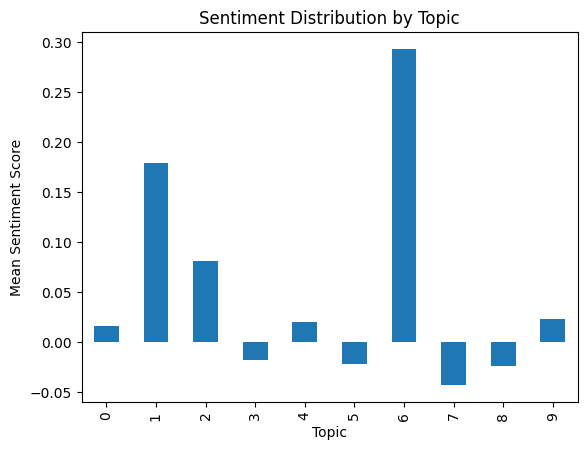

In [45]:
# Get the topic distribution for each document
topic_assignments = lda.transform(X_lda)

# Assign the most probable topic to each document
document_topics = np.argmax(topic_assignments, axis=1)

# Assuming you have already calculated the sentiment scores for each document and stored them in a list named sentiment_scores
df['sentiment_scores'] = df['sentiment']

# Add the assigned topic to the DataFrame
df['topic'] = document_topics

# Group by the assigned topic and calculate the mean sentiment score
mean_sentiment_by_topic = df.groupby('topic')['sentiment_scores'].mean()

# Plot the sentiment distribution for each topic
mean_sentiment_by_topic.plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Mean Sentiment Score')
plt.title('Sentiment Distribution by Topic')
plt.show()

#### 4. Named Entity Recognition

In [46]:
import spacy

# Load the English model
nlp = spacy.load("en_core_web_sm")

# Perform NER on a sample text
text = "Apple is looking to buy a UK startup for $1 billion"
doc = nlp(text)

# Print the named entities and their labels
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
UK 26 28 GPE
$1 billion 41 51 MONEY


Extracting named entities and storing in dataframe

In [47]:
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    return entities

df['entities'] = df['cleaned_content'].apply(extract_entities)

Analysing frequency of named entities, counting occurence of each in dataset

In [48]:
from collections import Counter

entity_counter = Counter()

for entities in df['entities']:
    for entity, label in entities:
        entity_counter[(entity, label)] += 1

# Print the 10 most common entities
print(entity_counter.most_common(20))

[(('today', 'DATE'), 644), (('one', 'CARDINAL'), 532), (('pakistan', 'GPE'), 509), (('india', 'GPE'), 508), (('first', 'ORDINAL'), 417), (('years', 'DATE'), 269), (('africa', 'LOC'), 214), (('un', 'ORG'), 211), (('china', 'GPE'), 177), (('two', 'CARDINAL'), 176), (('zero', 'CARDINAL'), 166), (('indian', 'NORP'), 138), (('us', 'GPE'), 132), (('egypt', 'GPE'), 124), (('yesterday', 'DATE'), 117), (('this year', 'DATE'), 116), (('uk', 'GPE'), 116), (('tomorrow', 'DATE'), 116), (('millions', 'CARDINAL'), 112), (('winter', 'DATE'), 109)]


#### entity frequency by region

In [49]:
region_content_df = df[['region', 'cleaned_content']]
grouped_region_content = region_content_df.groupby('region')['cleaned_content'].apply(lambda x: ' '.join(x)).reset_index()
grouped_region_content['entities'] = grouped_region_content['cleaned_content'].apply(extract_entities)
for index, row in grouped_region_content.iterrows():
    entity_counter = Counter()

    for entity, label in row['entities']:
        entity_counter[(entity, label)] += 1

    print(f"Top entities in {row['region']} region:")
    print(entity_counter.most_common(10))
    print("\n")


Top entities in Europe region:
[(('today', 'DATE'), 117), (('one', 'CARDINAL'), 103), (('first', 'ORDINAL'), 86), (('years', 'DATE'), 86), (('uk', 'GPE'), 81), (('zero', 'CARDINAL'), 81), (('two', 'CARDINAL'), 54), (('bbc', 'ORG'), 53), (('alexandria', 'PRODUCT'), 49), (('alexandria', 'NORP'), 40)]


Top entities in India & Pakistan region:
[(('pakistan', 'GPE'), 272), (('india', 'GPE'), 195), (('today', 'DATE'), 135), (('one', 'CARDINAL'), 95), (('first', 'ORDINAL'), 95), (('un', 'ORG'), 58), (('indian', 'NORP'), 50), (('this year', 'DATE'), 34), (('egypt', 'GPE'), 34), (('years', 'DATE'), 32)]


Top entities in North America region:
[(('one', 'CARDINAL'), 116), (('today', 'DATE'), 97), (('years', 'DATE'), 85), (('first', 'ORDINAL'), 76), (('republicans', 'NORP'), 73), (('democrats', 'NORP'), 67), (('us', 'GPE'), 64), (('americans', 'NORP'), 63), (('american', 'NORP'), 62), (('gop', 'ORG'), 58)]


Top entities in Oceania region:
[(('india', 'GPE'), 211), (('pakistan', 'GPE'), 205), ((

#### Entity frequency of top 20 countries by tweet count

In [50]:
nlp.max_length = 2000000  # 2 million characters
# Create the 'tweets_by_country' dataframe
tweets_by_country = df['country_name'].value_counts().reset_index()
tweets_by_country.columns = ['country_name', 'tweet_count']

country_content_df = df[['country_name', 'cleaned_content']]
grouped_country_content = country_content_df.groupby('country_name')['cleaned_content'].apply(lambda x: ' '.join(x)).reset_index()
grouped_country_content['entities'] = grouped_country_content['cleaned_content'].apply(extract_entities)

# Sort the dataframe by the tweet count and select the top 20 countries
top_20_countries = tweets_by_country.nlargest(20, 'tweet_count')['country_name'].tolist()
top_20_countries_df = grouped_country_content[grouped_country_content['country_name'].isin(top_20_countries)].reset_index(drop=True)

# Count the entities for each of the top 20 countries and display the top entities
for index, row in top_20_countries_df.iterrows():
    entity_counter = Counter()

    for entity, label in row['entities']:
        entity_counter[(entity, label)] += 1

    print(f"Top entities in {row['country_name']} country:")
    print(entity_counter.most_common(10))
    print("\n")


Top entities in Australia country:
[(('australia', 'GPE'), 11), (('china', 'GPE'), 8), (('one', 'CARDINAL'), 6), (('australian', 'NORP'), 6), (('tony abbott', 'PERSON'), 5), (('a decade', 'DATE'), 4), (('today', 'DATE'), 4), (('years', 'DATE'), 3), (('republicans', 'NORP'), 3), (('zero', 'CARDINAL'), 3)]


Top entities in Bangladesh country:
[(('today', 'DATE'), 32), (('first', 'ORDINAL'), 14), (('the year', 'DATE'), 10), (('dhaka', 'GPE'), 8), (('india', 'GPE'), 8), (('pakistan', 'GPE'), 8), (('one', 'CARDINAL'), 8), (('un', 'ORG'), 7), (('asia', 'LOC'), 6), (('dr hamidul', 'PERSON'), 4)]


Top entities in France country:
[(('first', 'ORDINAL'), 4), (('france', 'GPE'), 4), (('today', 'DATE'), 4), (('africa', 'LOC'), 4), (('years', 'DATE'), 3), (('two', 'CARDINAL'), 3), (('one', 'CARDINAL'), 3), (('bas', 'PERSON'), 2), (('europe', 'LOC'), 2), (('america', 'GPE'), 2)]


Top entities in Germany country:
[(('yanan', 'GPE'), 7), (('germany', 'GPE'), 6), (('one', 'CARDINAL'), 5), (('china',

Visualizing the frequency of the most common named entities

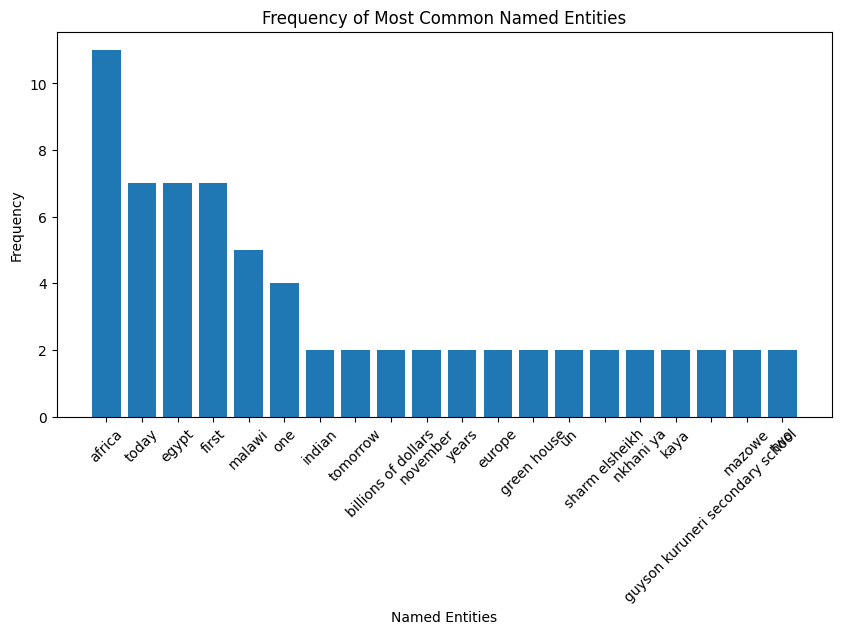

In [51]:
def plot_entity_frequencies(entity_counter, num_entities=10):
    most_common_entities = entity_counter.most_common(num_entities)
    entities = [item[0][0] for item in most_common_entities]
    frequencies = [item[1] for item in most_common_entities]
    
    plt.figure(figsize=(10, 5))
    plt.bar(entities, frequencies)
    plt.xlabel('Named Entities')
    plt.ylabel('Frequency')
    plt.title('Frequency of Most Common Named Entities')
    plt.xticks(rotation=45)
    plt.show()

plot_entity_frequencies(entity_counter, num_entities=20)

Grouping data by extracted location entities and calculate the mean sentiment scores for each group.

In [52]:
def extract_location_entities(entities):
    locations = []
    for entity, label in entities:
        if label == 'GPE' or label == 'LOC':
            locations.append(entity)
    return locations

df['locations'] = df['entities'].apply(extract_location_entities)

Now we have the location entities, calculate the mean sentiment scores for each location:

In [53]:
# Group by location
location_groups = df.explode('locations').groupby('locations')

# Calculate the mean sentiment score for each location
mean_sentiment_by_location = location_groups['sentiment_scores'].mean()

# Sort by sentiment score
mean_sentiment_by_location = mean_sentiment_by_location.sort_values(ascending=False)


Visualizing sentiment scores for the top N locations with the highest and lowest sentiment scores:

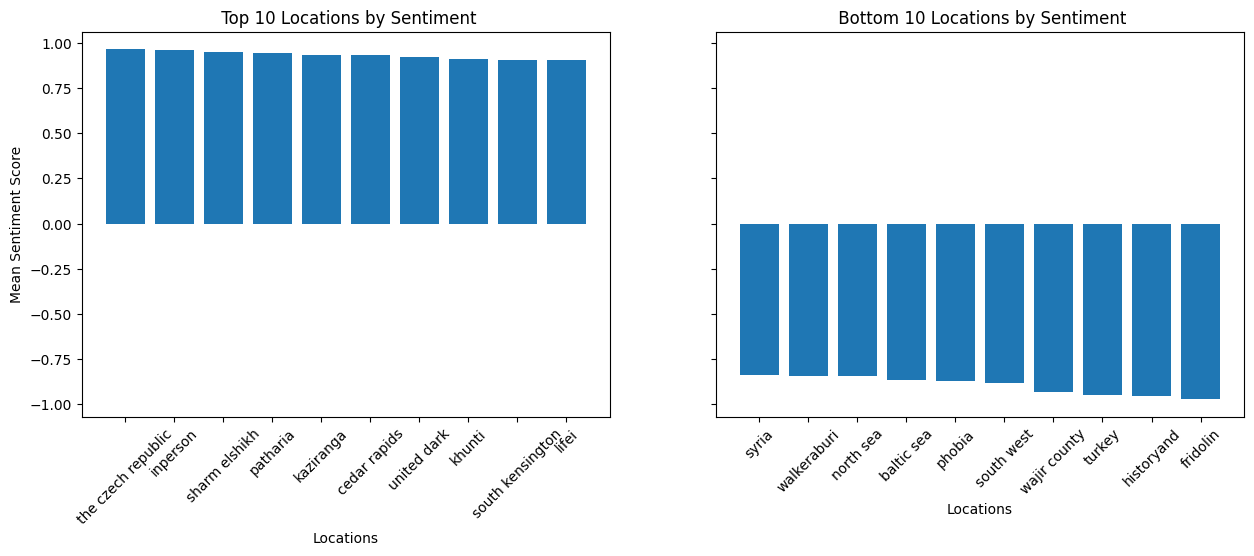

In [54]:
def plot_location_sentiment(mean_sentiment_by_location, num_locations=10, title_prefix=''):
    top_locations = mean_sentiment_by_location.head(num_locations)
    bottom_locations = mean_sentiment_by_location.tail(num_locations)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    
    ax1.bar(top_locations.index, top_locations.values)
    ax1.set_xlabel('Locations')
    ax1.set_ylabel('Mean Sentiment Score')
    ax1.set_title(f'{title_prefix} Top {num_locations} Locations by Sentiment')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(bottom_locations.index, bottom_locations.values)
    ax2.set_xlabel('Locations')
    ax2.set_title(f'{title_prefix} Bottom {num_locations} Locations by Sentiment')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.show()

plot_location_sentiment(mean_sentiment_by_location, num_locations=10)


##### Analyzing entity frequency for different regions or countries

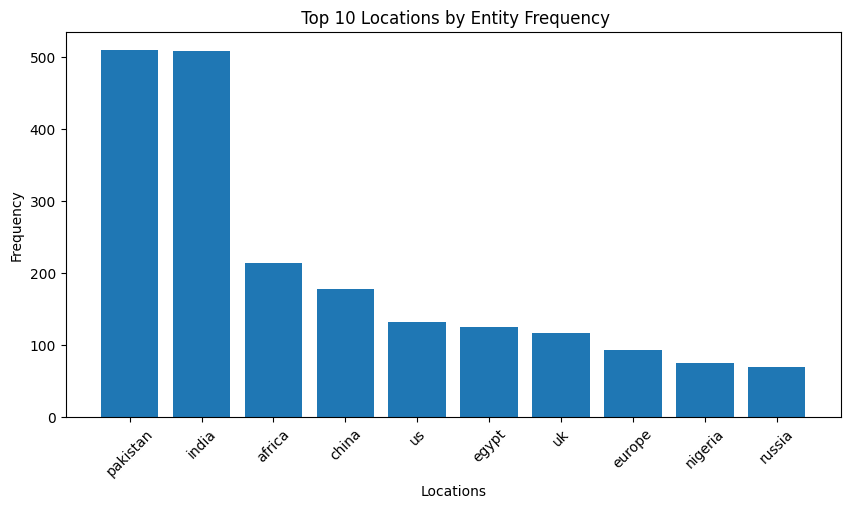

In [56]:
# Remove missing values and count location occurrences
location_counts = Counter(df.explode('locations')['locations'].dropna())

# Convert the counter to a Series
location_counts_series = pd.Series(location_counts).sort_values(ascending=False)

def plot_location_frequency(location_counts_series, num_locations=10, title_prefix=''):
    top_locations = location_counts_series.head(num_locations)
    
    plt.figure(figsize=(10, 5))
    plt.bar(top_locations.index, top_locations.values)
    plt.xlabel('Locations')
    plt.ylabel('Frequency')
    plt.title(f'{title_prefix} Top {num_locations} Locations by Entity Frequency')
    plt.xticks(rotation=45)
    plt.show()
plot_location_frequency(location_counts_series, num_locations=10)

### Analysis overall sentiment between locations

Group the data by location and calculate the mean sentiment score for each group. and Visualize the sentiment scores for the top N locations.


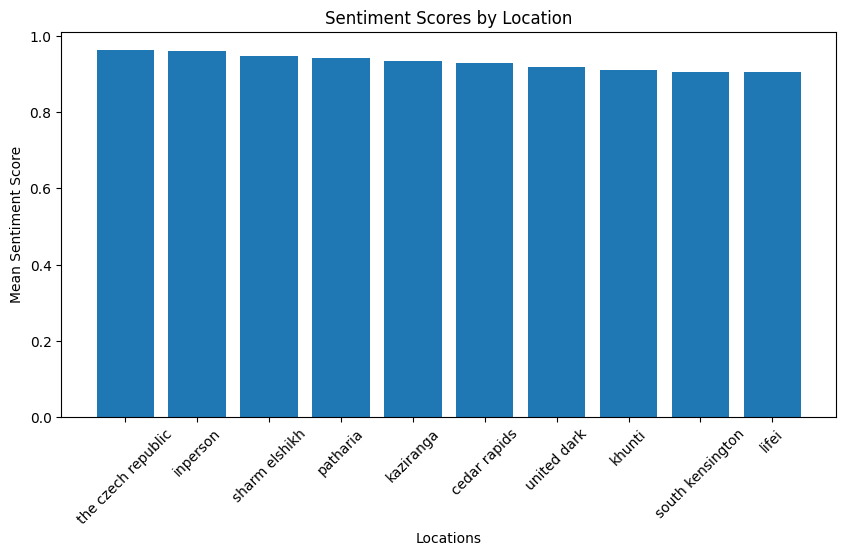

In [57]:
location_sentiment = df.explode('locations').groupby('locations')['sentiment_scores'].mean()

def plot_location_sentiment(location_sentiment, num_locations=10, title_prefix=''):
    top_locations = location_sentiment.sort_values(ascending=False).head(num_locations)

    plt.figure(figsize=(10, 5))
    plt.bar(top_locations.index, top_locations.values)
    plt.xlabel('Locations')
    plt.ylabel('Mean Sentiment Score')
    plt.title(f'{title_prefix}Sentiment Scores by Location')
    plt.xticks(rotation=45)
    plt.show()

plot_location_sentiment(location_sentiment, num_locations=10)


## 5. Conclusions

#### Summary

This study examines the sentiment of Twitter users from various countries and regions towards climate change. Using data from top countries with the highest tweet count, the research analyzed sentiment scores, top named entities related to climate change, and main themes or topics identified through Latent Dirichlet Allocation (LDA).

#### Limitations and Improvements

The study faced limitations such as potential bias in the tweet selection process and the possibility that the results may not accurately represent the general sentiment in each region or country as the collection process only allowed for tweets to be collected if a user had their geoloaction available, so the climate change tweets of all twitter accounts whose geolocation was not avilable were not considered. Also, as the twitter scraper program only gathered the most recent climate change tweets with geolocatino available, it is shown in the tweet date distribution visual that the tweets gathered from North America clearly data much further back than the other 4 regions, indicating there were less tweets fiting the parameters available from that region, this must be considered when comparing sentiment across regions and golbally sentiment can change over time, although as shown in the setiment distribution over tim eby specific countries, the plot of the U.S is shown to have consistently low sentiment score throughout. Additionally, the analysis relied on machine learning algorithms that may have misinterpreted certain contexts or emotions. Improvements could be made by increasing the sample size, using multiple sources of data, and refining the algorithms used for sentiment analysis and topic modeling.

#### Conclusions and Implications

The findings revealed that sentiment scores varied across countries and regions, with Southern Africa exhibiting the most positive entiment and North America showing the most negative sentiment. Named entities related to climate change varied across regions and countries also, which could indicate different perspectives and concerns regarding the issue. Moreover, the LDA-generated topics pointed to various themes and discussions surrounding cliate chnage. 

These results suggest that public opinion is diverse, and understanding these differences csn help inform targeted climate communication strategies and polices. It also highlights the importance of considering regional and cultural contexts when discussing climate chnage. 

#### Future Work

Future research could focus on exploring the reasons behind the differences in sentiment scores and named entities across regions and countries. This could involve investigating the role of socio-economic factors, political ideologies, and cultural beliefs in shaping public opinion on climate change. Furthermore, researchers could assess the impact of climate communication strategies on changing public sentiment and identify effective methods for engaging diverse audiences in climate action.



